In [3]:
import pandas as pd
df = pd.read_csv('../input/consumercomplaints/complaints.csv')
df.iloc[:,:10].head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX
4,2021-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33325


In [4]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679285 entries, 0 to 1999963
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 679285 non-null  object
 1   Product                       679285 non-null  object
 2   Sub-product                   627113 non-null  object
 3   Issue                         679285 non-null  object
 4   Sub-issue                     528206 non-null  object
 5   Consumer complaint narrative  679285 non-null  object
 6   Company public response       339012 non-null  object
 7   Company                       679285 non-null  object
 8   State                         675680 non-null  object
 9   ZIP code                      528244 non-null  object
 10  Tags                          111909 non-null  object
 11  Consumer consent provided?    679285 non-null  object
 12  Submitted via                 679285 non-null  object
 13

In [6]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [7]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [8]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [9]:
df['category_id'] = df['Product'].factorize()[0]

In [10]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# Mapping Dictionaries
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [11]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
3,Debt collection,Pioneer has committed several federal violatio...,0
8,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
9,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [10]:
import sys
sys.getsizeof(df)/(1024**3)

0.7826486974954605

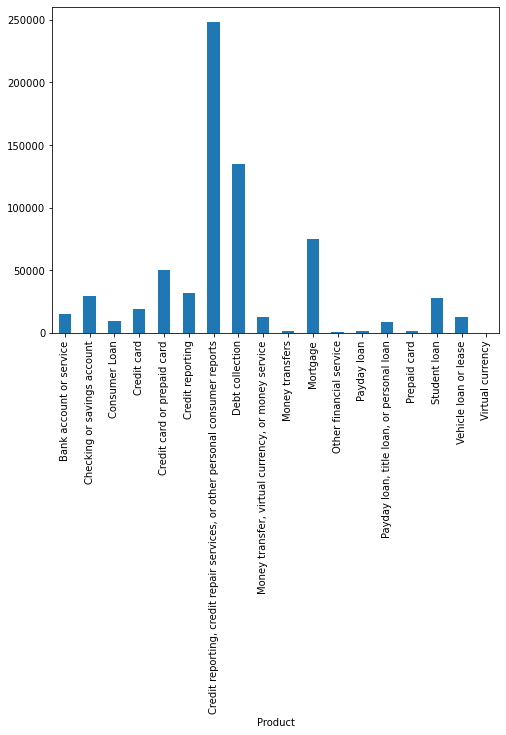

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(679285, 1072423)

In [13]:
import sys
sys.getsizeof(features)/(1024**3)

5.960464477539063e-08

In [14]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])

    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    # Top N most correlated unigrams and bigrams for each category
    df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
    df_cat['Product'] = product
    df_cat['Unigrams'] = unigrams[-N:]
    df_cat['Bigrams'] = bigrams[-N:]
  
    df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [15]:
df_feat.head(20)

,Product,Unigrams,Bigrams
0,Bank account or service,citigold,checking account
1,Bank account or service,overdraft,overdraft fees
2,Checking or savings account,checking,savings account
3,Checking or savings account,deposit,checking account
4,Consumer Loan,vehicle,auto loan
5,Consumer Loan,car,drive time
6,Credit card,macy,american express
7,Credit card,card,credit card
8,Credit card or prepaid card,citi,american express
9,Credit card or prepaid card,card,credit card


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [18]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [19]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [20]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
1640035,Debt collection,This company refuses to provide me verificatio...,0


In [21]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
1667242,Credit reporting,I am disputing the inaccurate information the ...,13


# Baseline Classifiers

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

# Model Selection using Cross Validation

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    #MultinomialNB(),
    #LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

    print(model_name)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
RandomForestClassifier
LinearSVC
LinearSVC


In [23]:
models = [
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df2 = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

    print(model_name)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df2 = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

MultinomialNB
MultinomialNB
LogisticRegression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression


In [25]:
cv_df = pd.concat([cv_df, cv_df2], axis=0)

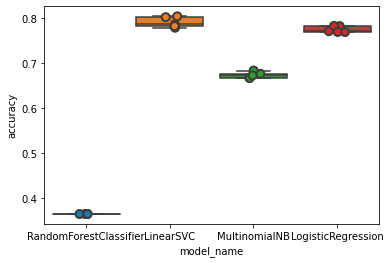

In [26]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [27]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.790721
LogisticRegression        0.774987
MultinomialNB             0.673554
RandomForestClassifier    0.365259
Name: accuracy, dtype: float64

# Best model - LinearSVC

In [16]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

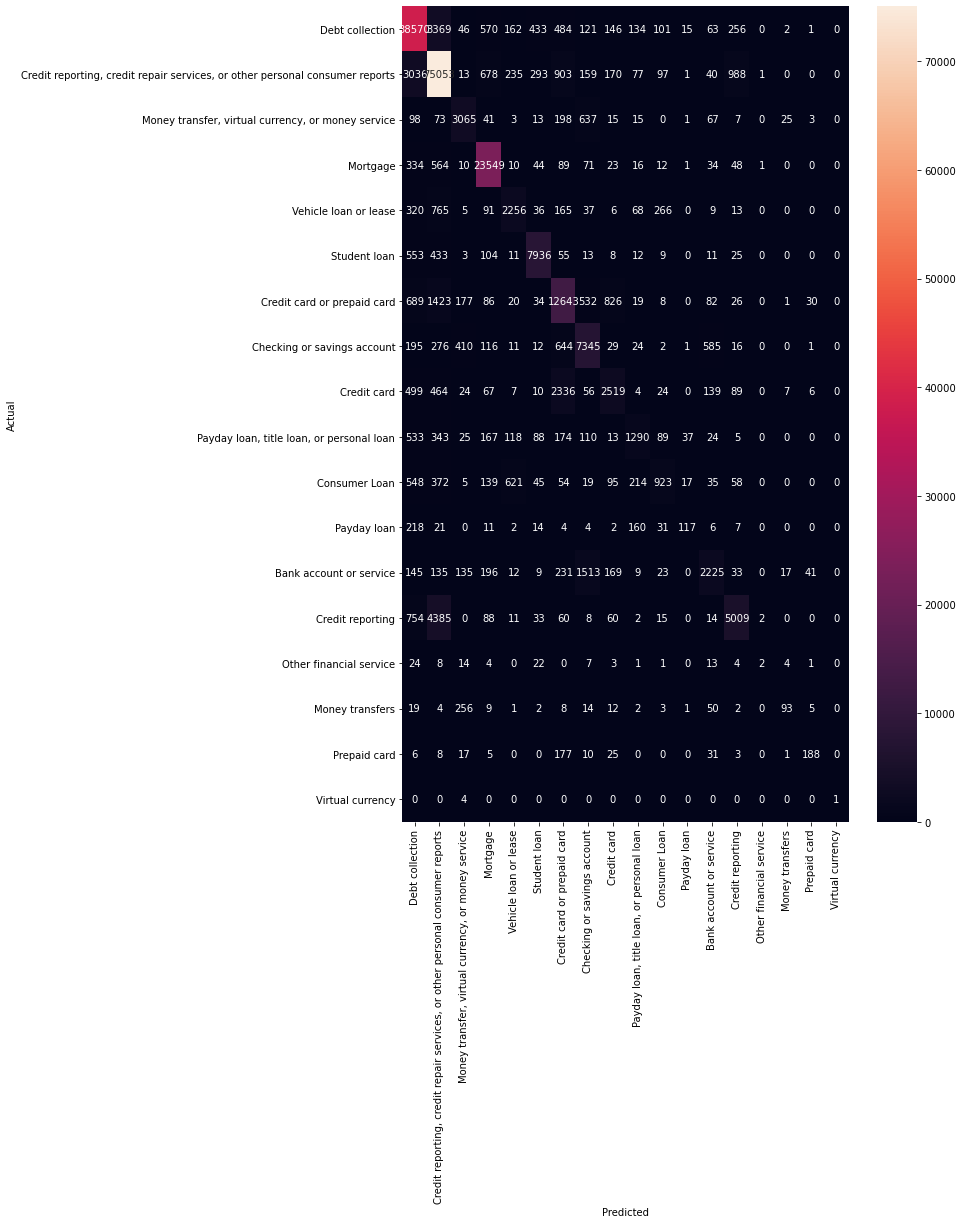

In [28]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 3036 examples.


,Product,Consumer_complaint_narrative
8403,"Credit reporting, credit repair services, or o...",this is not my debt it belongs to my sister wh...
331138,"Credit reporting, credit repair services, or o...",All paid as agreed upon.
1863514,"Credit reporting, credit repair services, or o...","The collection company, XXXX, has posted erron..."
1903463,"Credit reporting, credit repair services, or o...",Gap card sent me an invoice in XX/XX/2017 for ...
711420,"Credit reporting, credit repair services, or o...",Discovery and Determination of Alleged Student...
...,...,...
1372815,"Credit reporting, credit repair services, or o...",Account Number Creditor Information XXXX ****...
752726,"Credit reporting, credit repair services, or o...",I requested debt validation which was never re...
225429,"Credit reporting, credit repair services, or o...",This has already been removed from my credit r...
902490,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX. I received a debt collector let...



'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 98 examples.


,Product,Consumer_complaint_narrative
1211880,"Money transfer, virtual currency, or money ser...",On XX/XX/2019 I made a payment to Paypal. At t...
98283,"Money transfer, virtual currency, or money ser...",I PAID IN 2016 OVER {$20000.00} TO 2 COMPANIES...
1898041,"Money transfer, virtual currency, or money ser...",My daughter called me to inform me that we rec...
1821144,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX my PayPal account ( created sinc...
135700,"Money transfer, virtual currency, or money ser...",I responded to an add for a puppy. The company...
...,...,...
1916158,"Money transfer, virtual currency, or money ser...","I checked my PayPal account on XX/XX/2018, and..."
376642,"Money transfer, virtual currency, or money ser...",I Purchased a baby kitten on XXXX for {$300.00...
761758,"Money transfer, virtual currency, or money ser...",I made a purchase of jewelry that had a precis...
410290,"Money transfer, virtual currency, or money ser...",I cashapped a person XXXX and the person ended...



'Mortgage' predicted as 'Debt collection' : 334 examples.


,Product,Consumer_complaint_narrative
1916520,Mortgage,I keep getting phone calls saying that I am be...
1993424,Mortgage,I asked for my promissary note as the only sig...
1632685,Mortgage,Addendum number XXXX : XXXX ( unintelligible l...
661834,Mortgage,Unlawful debt collection : Trustee sale is voi...
1035160,Mortgage,submission # XXXX SELECT PORTFOLIO SERVICING I...
...,...,...
843513,Mortgage,"Quality Loan Service Corporation, the non-judi..."
372422,Mortgage,me and my wife seprate in XX/XX/XXXX and the h...
783910,Mortgage,XXXX DI TECH Financial LLC XXXX . XXXX ...
1614723,Mortgage,"In XX/XX/XXXX we did a short sale of our home,..."



'Vehicle loan or lease' predicted as 'Debt collection' : 320 examples.


,Product,Consumer_complaint_narrative
1805569,Vehicle loan or lease,I obtained an auto loan back with ALLY FINANCI...
146677,Vehicle loan or lease,XXXX XXXX of Larry H Miller XXXX illegally dis...
1957075,Vehicle loan or lease,Go Financial is reporting a outstanding balanc...
252748,Vehicle loan or lease,I just got my car repose and pay a full amount...
914662,Vehicle loan or lease,On XX/XX/XXXX XXXX XXXX quoted me a payoff amo...
...,...,...
900470,Vehicle loan or lease,"On XXXX XXXX, I made a payment to Ally Financi..."
60531,Vehicle loan or lease,Do not give me a chance to make agreement to p...
1856471,Vehicle loan or lease,I am a veteran that suffered XXXX XXXX from se...
915044,Vehicle loan or lease,"on XX/XX/XXXX, Ally called my mom looking for ..."



'Student loan' predicted as 'Debt collection' : 553 examples.


,Product,Consumer_complaint_narrative
1651706,Student loan,Pursuant to a letter I received from XXXX ( XX...
1716110,Student loan,Navient has been on my credit report for some ...
1681185,Student loan,Yesterday I received the list with the rehabil...
380882,Student loan,I got this loan in XX/XX/XXXX and I am being c...
1717054,Student loan,I no longer have an account there and they sti...
...,...,...
1895967,Student loan,"I have been dealing with XXXX XXXX, and i have..."
123317,Student loan,These student loans are not mine The home I wa...
4555,Student loan,A couple of weeks ago I received an email from...
1632116,Student loan,I requested proof that this loan was mine with...



'Credit card or prepaid card' predicted as 'Debt collection' : 689 examples.


,Product,Consumer_complaint_narrative
1800206,Credit card or prepaid card,I have recived a bill from capital one saying ...
830779,Credit card or prepaid card,"In XX/XX/XXXX, I received a bill from XXXX XXX..."
768306,Credit card or prepaid card,Per Previous Complaint # XXXX The ( XX/XX/XXXX...
672663,Credit card or prepaid card,XX/XX/XXXX I was notified of an unauthorized c...
332293,Credit card or prepaid card,I did not get this card. I have not lived in t...
...,...,...
954358,Credit card or prepaid card,I have many new accounts with XXXX XXXX. And j...
187666,Credit card or prepaid card,This kind of account is placed as a charged of...
1868443,Credit card or prepaid card,I have had my XXXX XXXX enrolled in autopay fo...
526283,Credit card or prepaid card,OK HAD LEFT AN ACCOUNT GO DORMANT THEN I NEEDE...



'Checking or savings account' predicted as 'Debt collection' : 195 examples.


,Product,Consumer_complaint_narrative
81938,Checking or savings account,XXXX Our bank XXXX contacted my business to sa...
160481,Checking or savings account,There was an account opened with Chase Bank fr...
823746,Checking or savings account,Refuses to send updated account information to...
483657,Checking or savings account,"On XX/XX/XXXX, while attempting to do an Early..."
1970022,Checking or savings account,1. Date opened XX/XX/2014 a credit card for XX...
...,...,...
1996105,Checking or savings account,"Re : XX/XX/XXXX & TODAY, XX/XX/XXXX TWO DATES,..."
994720,Checking or savings account,XXXX XXXX and XXXX XXXX from citibank executi...
1871252,Checking or savings account,"To Whom It May Concern, This is my third attem..."
373537,Checking or savings account,I originally saw {$3600.00} outstanding. I hav...



'Credit card' predicted as 'Debt collection' : 499 examples.


,Product,Consumer_complaint_narrative
1745937,Credit card,XXXX has been calling me over XXXX times every...
1691744,Credit card,The XXXX Homedepot collected a payment of {$52...
1734873,Credit card,My corporation dissolved in XXXX of 2013. I ha...
1659299,Credit card,"On or after XXXX XXXX, 2011, I opened an accou..."
1793914,Credit card,A few years ago I contact ed Citi bank regard...
...,...,...
1610745,Credit card,I have an outstanding balance on my credit acc...
1703459,Credit card,Capital One has intimidated and harasses me an...
1703573,Credit card,i used a XXXX servive through store added to b...
1710959,Credit card,I have been a loyal customer of XXXX XXXX for ...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 533 examples.


,Product,Consumer_complaint_narrative
184112,"Payday loan, title loan, or personal loan",On XX/XX/XXXX My ex husband and I entered into...
1853698,"Payday loan, title loan, or personal loan",""" XXXX '' from XXXX XXXX XXXX, is obsessively ..."
357279,"Payday loan, title loan, or personal loan",Numerous calls throughout day and night and no...
22140,"Payday loan, title loan, or personal loan",I got in bind in XXXX because my check was sho...
811651,"Payday loan, title loan, or personal loan","No one wants to have to borrow money, but some..."
...,...,...
886111,"Payday loan, title loan, or personal loan",I had already had a loan with company and only...
506748,"Payday loan, title loan, or personal loan",I received information from you attempting to ...
492548,"Payday loan, title loan, or personal loan",1. BBVA Line of Credit we had matured XX/XX/20...
551766,"Payday loan, title loan, or personal loan",I have received calls and email threaten me ab...



'Consumer Loan' predicted as 'Debt collection' : 548 examples.


,Product,Consumer_complaint_narrative
1671859,Consumer Loan,I got a loan from Spot Loan a few months ago a...
1685182,Consumer Loan,"The loan company, Flagship Credit Acceptance, ..."
1639332,Consumer Loan,I went to XXXX XXXX XXXX to get options to tra...
1644958,Consumer Loan,Ally Financial is claiming my mother and I owe...
1659677,Consumer Loan,I filed a complaint to you back in XXXX 2015 d...
...,...,...
1650975,Consumer Loan,Lobel Financial is harrassing me at work. I am...
1688065,Consumer Loan,Lobel Financial increased the amount showing f...
1676646,Consumer Loan,I took out a loan with Cash Call back on XXXX/...
832858,Consumer Loan,Nissan Acceptance Corp is listing a debt on my...



'Payday loan' predicted as 'Debt collection' : 218 examples.


,Product,Consumer_complaint_narrative
1683131,Payday loan,"I was contacted by High Point Asset, Inc. pert..."
1659657,Payday loan,I contact AD ASTRA RECOVERY SERVICES at XXXX t...
1678206,Payday loan,I set up a date with the collector from ez mon...
50745,Payday loan,I have received phone calls at my home and pla...
840466,Payday loan,I filed a complaint against Ace Cash Express a...
...,...,...
1024288,Payday loan,"On XXXX XXXX, XXXX, XXXX of my family members ..."
1658406,Payday loan,The lender is making multiple calls per day to...
1749680,Payday loan,I was told this a pre trail intervention to ca...
1640669,Payday loan,"I repaid a loan to ACE Cash Express in 2011, I..."



'Bank account or service' predicted as 'Debt collection' : 145 examples.


,Product,Consumer_complaint_narrative
1661648,Bank account or service,I had a XXXX scammer from XXXX ruin my account...
1744547,Bank account or service,I was scammed out a get money quick theme. He ...
1663246,Bank account or service,I am the executrix of my mother 's estate. She...
1609468,Bank account or service,"XXXX XXXX, Ga. XXXX Acct # XXXX. \nI have sent..."
1718002,Bank account or service,Almost {$600.00} of my financial aid was taken...
...,...,...
1740450,Bank account or service,I called Banco Popular on XX/XX/XXXX to make t...
1741697,Bank account or service,Synchrony Bank/JCP ; Has presumed that I owe t...
1671192,Bank account or service,I entered into an agreement several months ago...
1690993,Bank account or service,US Bank sent me to check systems for XXXX I ha...



'Credit reporting' predicted as 'Debt collection' : 754 examples.


,Product,Consumer_complaint_narrative
1712157,Credit reporting,Debt collector ( XXXX. ) collecter did n't ver...
1644098,Credit reporting,"XXXX, XXXX and XXXX, XXXX have been misreporti..."
1657571,Credit reporting,I have a {$3400.00} debt listed on my credit r...
1615345,Credit reporting,I am having a problem with Portfolio Recovery ...
1705002,Credit reporting,I have reported the information to the company...
...,...,...
1701911,Credit reporting,I am a victim of identity theft. Several years...
1025885,Credit reporting,"Today, XX/XX/XXXX, I received in the U.S. mail..."
1674129,Credit reporting,Collection is being reported that was paid to ...
1702227,Credit reporting,I am requesting validation of a judgement reco...



'Other financial service' predicted as 'Debt collection' : 24 examples.


,Product,Consumer_complaint_narrative
1634629,Other financial service,Certegy XXXX XXXX has a file of my name and an...
1629090,Other financial service,"The cashier named XXXX XXXX, working in the Ch..."
1697469,Other financial service,Received a letter in mail written XXXX XXXX re...
1622268,Other financial service,I received a letter in the mail from Sofi or S...
739586,Other financial service,"Cornerstone Legal Group , LLC XXXX XXXX XXXX X..."
1060935,Other financial service,"I find that this company, Riverwalk Debt Solut..."
1687110,Other financial service,After speaking with the handler of my student ...
1790510,Other financial service,Back in XXXX of XXXX I had credit card debt. I...
1643270,Other financial service,Global Client Solutions through XXXX XXXX XXXX...
1662952,Other financial service,We had a lot of debt with credit cards etc and...



'Money transfers' predicted as 'Debt collection' : 19 examples.


,Product,Consumer_complaint_narrative
971983,Money transfers,I did a international transfer on XX/XX/2016 o...
1755801,Money transfers,I own a XXXX. I entered into a contract withMo...
1694562,Money transfers,XX/XX/2016 - centurylink account closed XX/XX/...
1660345,Money transfers,"Used a phone at a CVS on XXXX and XXXX XXXX, X..."
1658972,Money transfers,I had purchased goods via paypal services but ...
858000,Money transfers,I recently sent {$100.00} to a guy who I sort ...
1695847,Money transfers,I submitted money to a XXXX Confererence organ...
1710816,Money transfers,Paypal went ahead and put limitations on my ac...
1782925,Money transfers,XX/XX/XXXX one of my sons asked me to pay his ...
1643822,Money transfers,"In XXXX, 2016, I was contacted by XXXX and off..."



'Prepaid card' predicted as 'Debt collection' : 6 examples.


,Product,Consumer_complaint_narrative
1677037,Prepaid card,XXXX XXXX Services froze my XXXX computer scre...
1741999,Prepaid card,I buy a pre-paid phone card for my smartphone ...
1704102,Prepaid card,I have been on the phone and ca n't get throug...
1695903,Prepaid card,I placed {$2000.00} on deposit was never paid ...
1652683,Prepaid card,The company promised free reloads upon initiat...
1607991,Prepaid card,When first opened the account there was a pref...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 3369 examples.


,Product,Consumer_complaint_narrative
1937821,Debt collection,I have been a victim of identity theft.
264799,Debt collection,I purchased a home XX/XX/2019 ; during the pro...
1994451,Debt collection,Account is not mine
1623044,Debt collection,I have XXXX filings in my credit for XXXX apar...
1001583,Debt collection,I looked up my credit history and it shows jet...
...,...,...
959577,Debt collection,I was away in XXXX for 10 years when I came ba...
380934,Debt collection,They are putting a derogatory mark on my credi...
1117382,Debt collection,I did not apply for
1697822,Debt collection,Never have been a XXXX XXXX customer. I was at...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 73 examples.


,Product,Consumer_complaint_narrative
1800948,"Money transfer, virtual currency, or money ser...",a check cashing service company used by XXXX X...
110465,"Money transfer, virtual currency, or money ser...",I have enrolled with New Direction Debt Relief...
973933,"Money transfer, virtual currency, or money ser...",I have some concerns about the information tha...
12869,"Money transfer, virtual currency, or money ser...",I noticed three unauthorized transactions on m...
313849,"Money transfer, virtual currency, or money ser...",I signed on in XX/XX/XXXX to a debt settlement...
...,...,...
859826,"Money transfer, virtual currency, or money ser...",Hello! \nMy account on the XXXX XXXX was block...
181169,"Money transfer, virtual currency, or money ser...",Account was closed on XX/XX/19 when only actio...
139553,"Money transfer, virtual currency, or money ser...",I am a victim of identity theft and have worke...
945695,"Money transfer, virtual currency, or money ser...",Nothing really happing I 'm a really good hard...



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 564 examples.


,Product,Consumer_complaint_narrative
52238,Mortgage,Please see the attached detail complaint. My p...
1690289,Mortgage,I just recently discovered that I had XXXX har...
322464,Mortgage,I was shocked when I reviewed my credit report...
1555473,Mortgage,I had a mortgage that was refinanced in XX/XX/...
1996392,Mortgage,Background : I have a checking account and Lin...
...,...,...
1724825,Mortgage,Bank of America sold my mortgage XX/XX/2013. A...
914639,Mortgage,In XXXX XXXX 2017 I sent an actual live check ...
480066,Mortgage,My loan was PAID IN FULL on XX/XX/2020. On XXX...
1615832,Mortgage,Please see attached NOTICE OF INVALID INSTRUME...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 765 examples.


,Product,Consumer_complaint_narrative
541367,Vehicle loan or lease,"In 2017, I had a car loan with Regional Accept..."
51393,Vehicle loan or lease,I co-signed for my son-in-law 's XXXX Honda XX...
607125,Vehicle loan or lease,I applied for a loan on XX/XX/XXXX. I received...
140072,Vehicle loan or lease,I recently responded to a advertisement for fi...
66175,Vehicle loan or lease,"WFS just sent me a XXXX dollar reimbursement, ..."
...,...,...
112503,Vehicle loan or lease,Go Financial authorized a fraudulent loan in m...
190909,Vehicle loan or lease,I applied for a loan on a used XXXX XXXX and w...
885576,Vehicle loan or lease,Flagship Credit Acceptance has not been proces...
112810,Vehicle loan or lease,I submitted a complaint yesterday and have fou...



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 433 examples.


,Product,Consumer_complaint_narrative
1726028,Student loan,Discover Student Loans reported in error to XX...
1918397,Student loan,I have twice submitted for employment certific...
1697410,Student loan,I noticed a problem with my loan in XXXX XXXX ...
1886811,Student loan,On XX/XX/2018 Nelnet reported my account 90 da...
1362499,Student loan,-they falsified my application ( family size ...
...,...,...
861602,Student loan,I was shocked when I reviewed my credit report...
574490,Student loan,I've sent several letters since XX/XX/2019 to ...
996466,Student loan,There are multiple accounts from XXXX XXXX XXX...
1919620,Student loan,"On XX/XX/XXXX, I checked my XXXX XXXX account ..."



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 1423 examples.


,Product,Consumer_complaint_narrative
171586,Credit card or prepaid card,I was shocked when I reviewed my credit report...
946023,Credit card or prepaid card,XXXX REPORT ; XXXX XXXX XXXX XX/XX/XX...
880581,Credit card or prepaid card,"NOT MINE, NO LEGAL CONTRACT, not authorized, n..."
875168,Credit card or prepaid card,This company XXXX wanted to check my credit re...
62056,Credit card or prepaid card,I am writing you today as an aggrieved man. FI...
...,...,...
858456,Credit card or prepaid card,This is a Capitol one prepaid card. The proble...
948356,Credit card or prepaid card,I opened a credit card with Discover bank in X...
1943579,Credit card or prepaid card,Hi thank you for your time. I applied for Disc...
850823,Credit card or prepaid card,I was subjected to deceptive trade practices. ...



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 276 examples.


,Product,Consumer_complaint_narrative
1852621,Checking or savings account,froze my account costing me money i cant pay m...
154906,Checking or savings account,I have recently been informed that there is ne...
1160834,Checking or savings account,XXXX XXXX XXXX is reporting fraudulent accoun...
614915,Checking or savings account,Experian Credit illegally obtained my debit ca...
29621,Checking or savings account,"On Wednesday XXXX XXXX, I wasn't able to acces..."
...,...,...
586713,Checking or savings account,"On XX/XX/XXXX, I was looking for a job on XXXX..."
794829,Checking or savings account,STOLEN IDENTITY LEAD TO A BANK OF AMERICA ACCO...
1933681,Checking or savings account,On XX/XX/XXXX Pay Pal sent myself a letter to ...
63889,Checking or savings account,I had a XXXX XXXX XXXX checking account and ha...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 464 examples.


,Product,Consumer_complaint_narrative
1737333,Credit card,Capital One has reported both of my cards as 3...
1571293,Credit card,I had a payment due for a line of credit from ...
1685174,Credit card,I opened a secured credit card with XXXX XXXX ...
1616285,Credit card,The purchase was made online at XXXX XXXX XXXX...
1666020,Credit card,XXXX transferred my XXXX card into a XXXX XXXX...
...,...,...
1642469,Credit card,I have XXXX separate credit cards that were wi...
1792458,Credit card,On XX/XX/2017 my cc was lost reported right aw...
1657703,Credit card,Alleged outstanding balance paid online using ...
1731221,Credit card,i checked my credit report for XXXX and XXXX a...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 343 examples.


,Product,Consumer_complaint_narrative
998424,"Payday loan, title loan, or personal loan",LONG STORY SHORT one main financial allowed ME...
161294,"Payday loan, title loan, or personal loan",I have several complaints to lodge against Len...
299238,"Payday loan, title loan, or personal loan",I had an established loan with The XXXX XXXX X...
1951678,"Payday loan, title loan, or personal loan",I received an alert from credit monitoring ser...
1891628,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I got a personal loan for {$1600...
...,...,...
562365,"Payday loan, title loan, or personal loan",In XX/XX/2020 I spoke with the customer servic...
79398,"Payday loan, title loan, or personal loan",The interest rate is like 200 % interest. I th...
875613,"Payday loan, title loan, or personal loan",XXXX/XXXX/XXXX {$400.00} I called numerous tim...
858407,"Payday loan, title loan, or personal loan",I paid the late fee and regular payment for XX...



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 372 examples.


,Product,Consumer_complaint_narrative
1688111,Consumer Loan,An inquiry for SunTrust Bank appeared on my XX...
1655608,Consumer Loan,I have completed all payments toAlly Financial...
1749672,Consumer Loan,The payment on the account for the month of XX...
1645434,Consumer Loan,Earlier this month ( XX/XX/XXXX ) I contacted ...
1667184,Consumer Loan,I contacted BMW financial about my auto loan a...
...,...,...
1790290,Consumer Loan,how many days are in billing cycle ending XXXX...
1704445,Consumer Loan,I am filing this complaint against TD Auto Fin...
1665561,Consumer Loan,The company has been incorrectly reporting tha...
1725992,Consumer Loan,"I filed bankruptcy in XXXX, it was dismissed. ..."



'Payday loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 21 examples.


,Product,Consumer_complaint_narrative
1571342,Payday loan,The collection agency is reporting that i open...
1642460,Payday loan,I was investigating the possibility of obtaini...
1674905,Payday loan,I applied for US bank loan in the amount of {$...
1701061,Payday loan,"I have permanently "" opted out '' from unsolic..."
1611049,Payday loan,I received an email Check n Go denying a loan ...
1703325,Payday loan,I apply for XXXX loan from Cassle Payday I was...
1783983,Payday loan,I got an inquiry on my credit report from Cash...
1677477,Payday loan,"Insta Loan, XXXX XXXX Ga, PROMISED me they wou..."
1639211,Payday loan,I paid my loan off within the 30 days before t...
1728179,Payday loan,"I received a copies of my XXXX, XXXX, and XXXX..."



'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 135 examples.


,Product,Consumer_complaint_narrative
1718302,Bank account or service,I had a mortgage with US Bank and was advised ...
1728562,Bank account or service,JP Morgan Chase and XXXX XXXX in the Executive...
1727155,Bank account or service,I wanted to update my last name after my divor...
1719991,Bank account or service,I applied for a credit card for my business wi...
1694227,Bank account or service,XXXX XXXX XXXX has XXXX checks with the dates ...
...,...,...
1738170,Bank account or service,After filing a formal comlaint with your organ...
1216468,Bank account or service,"XXXX XXXX XXXX XXXX, North Dakota and Washingt..."
1715464,Bank account or service,Hi I applied for a capital one credit card on ...
1609264,Bank account or service,I received a letter from a stranger stating th...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 4385 examples.


,Product,Consumer_complaint_narrative
1662741,Credit reporting,"XXXX XXXX, New Jersey XXXX department increase..."
1642772,Credit reporting,"While reviewing my credit report, I came upon ..."
1700238,Credit reporting,"Hi, I have Never went by the name XXXX ..I wou..."
1602552,Credit reporting,On XXXX XXXX of 2015 I requested my Experian c...
1794088,Credit reporting,Experian show s XXXX old accounts ( 4-6 y...
...,...,...
1669981,Credit reporting,Experian reporting account incorrectly in rega...
1733633,Credit reporting,I have XXXX accounts on my credit report. I wa...
1694917,Credit reporting,In XXXX XXXX my account was accessed ( not by ...
1781821,Credit reporting,Equifax has not responded according to the Fed...



'Other financial service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 8 examples.


,Product,Consumer_complaint_narrative
778052,Other financial service,I was notified by a creditor that my personal ...
1741873,Other financial service,I was initially denied the ability to cash a c...
1786832,Other financial service,I opt in to receive assistance from XXXX XX...
1784471,Other financial service,I am submitting a complaint in regards to a ba...
1787123,Other financial service,After reading all of the positive reviews from...
1725773,Other financial service,"HELLO, Re : Account # XXXX I have called asked..."
1625505,Other financial service,Springleaf Finance have XXXX hard inquiries on...
86628,Other financial service,"On Saturday, I started receiving text messages..."



'Prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 8 examples.


,Product,Consumer_complaint_narrative
1724842,Prepaid card,I was offered a pre-paid card from Continental...
1577093,Prepaid card,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...
1682442,Prepaid card,we are having problems with rushcard in the la...
1618505,Prepaid card,Will discuss upon receiving notification.
1610582,Prepaid card,I purchased XXXX XXXX XXXX card ( issed by inc...
1062979,Prepaid card,A Friend of mine gave me this Debit Master Car...
769494,Prepaid card,for weeks my check been delayed late post it '...
1727493,Prepaid card,First progress ( FP ) a prepaid credit card co...



'Debt collection' predicted as 'Money transfer, virtual currency, or money service' : 46 examples.


,Product,Consumer_complaint_narrative
143864,Debt collection,Have been using the Venmo app for almost 3 yea...
1649932,Debt collection,i got a letter from PayPal inc charging me {$9...
1676762,Debt collection,they do n't have a number to contact them by. ...
454112,Debt collection,I received an email about a non-existent debt ...
924023,Debt collection,"On XX/XX/XXXX, 2017, my phone and wallet were ..."
990099,Debt collection,XXXX created a fake transaction about a bad ch...
613895,Debt collection,Hello I have sent PayPal all conversations and...
492017,Debt collection,The hacker attacked my PayPal account on XX/XX...
989997,Debt collection,I had an account with XXXX. My relationship wi...
552697,Debt collection,I ordered a game system from XXXX and paid usi...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Money transfer, virtual currency, or money service' : 13 examples.


,Product,Consumer_complaint_narrative
982551,"Credit reporting, credit repair services, or o...",I sold my two used authentic XXXX watches on b...
594489,"Credit reporting, credit repair services, or o...",My cash app account was locked on the XXXX of ...
288087,"Credit reporting, credit repair services, or o...",This seems to be the same issue when you guys ...
244295,"Credit reporting, credit repair services, or o...",Google is working with developers of online ga...
25355,"Credit reporting, credit repair services, or o...","( 1 ) XX/XX/2019, XX/XX/2019, XX/XX/2019 ( 2 )..."
77285,"Credit reporting, credit repair services, or o...",I was recently notified that there was a hard ...
434881,"Credit reporting, credit repair services, or o...",Google XXXX has been deleting my bad reviews o...
1888332,"Credit reporting, credit repair services, or o...",I'm trying to cash a check at XXXX and keep ge...
96819,"Credit reporting, credit repair services, or o...",I open an Paypal account and my account closed...
251177,"Credit reporting, credit repair services, or o...",On XX/XX/2020 XXXX XXXX and XXXX XXXX attempte...



'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 10 examples.


,Product,Consumer_complaint_narrative
1922212,Mortgage,PLEASE FURNISH ALL WIRE TRANSFERS MADE BY M FR...
660305,Mortgage,We submitted an application for a loan modific...
942360,Mortgage,Citigroup has decided to make banking decision...
328248,Mortgage,"To acquire a mortgage through XXXX XXXX XXXX, ..."
258613,Mortgage,So I received a trial modification in XXXX fir...
709889,Mortgage,XXXX XXXX XXXX XXXX Get my money back please
79217,Mortgage,My condo was paid off. I did a cash out refina...
709239,Mortgage,Deceased owner of the account XXXX XXXX XXXX X...
506420,Mortgage,I am refinancing my home loan through Bay Vall...
1008342,Mortgage,I have not been paid by XXXX XXXX investor Ven...



'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 177 examples.


,Product,Consumer_complaint_narrative
991012,Credit card or prepaid card,I purchased a XXXX XXXX XXXX from XXXX on the ...
294126,Credit card or prepaid card,I purchased two tickets with XXXX XXXX using P...
631996,Credit card or prepaid card,Withholding a transfer to my account. Verified...
437632,Credit card or prepaid card,"PayPal overestimates foreign exchange costs, t..."
1801232,Credit card or prepaid card,"On XX/XX/XXXX, I bought two XXXX the musical t..."
...,...,...
147966,Credit card or prepaid card,I have been a customer with CASH App for sever...
104539,Credit card or prepaid card,So Paypal Reversed a bunch of fraudulent trans...
1971652,Credit card or prepaid card,USAA has been charging me false cash advance f...
476237,Credit card or prepaid card,I overpaid a bill in the amount of {$27000.00}...



'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 410 examples.


,Product,Consumer_complaint_narrative
616901,Checking or savings account,XXXX XXXX spoke to my bank about transactions ...
233412,Checking or savings account,Nothing was done by my bank. There was a payme...
1818871,Checking or savings account,My name is XXXX XXXX. I am XXXX y/o ; I am US ...
945410,Checking or savings account,On Friday XX/XX/XXXXan electronic wire transfe...
987524,Checking or savings account,This issue is for believed fraudulent activity...
...,...,...
878764,Checking or savings account,"Dear Sir or Madam, Back in XXXX, when my wife ..."
409244,Checking or savings account,Unable to link bank account.
285476,Checking or savings account,Im unable to link my virtual wallet account at...
696065,Checking or savings account,Im trying to set up an online investment portf...



'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 24 examples.


,Product,Consumer_complaint_narrative
1738216,Credit card,I stopped using Paypal a while ago. I tried to...
1651302,Credit card,I sold a XXXX minibike with a new XXXX engine ...
1642573,Credit card,We 've had a PayPal account for years and year...
1692038,Credit card,A buyer has purchased a watch from me online a...
1646268,Credit card,PayPal has a repeated POOR BUSINESS PRACTICE o...
1735598,Credit card,I started using this service on XXXX as i have...
1684524,Credit card,I have a PayPal credit account. The credit acc...
1698601,Credit card,"On XXXX XXXX, XXXX, I purchase XXXX XXXX XXXX ..."
1721706,Credit card,I can not log into my account and they will no...
1061094,Credit card,PayPal - I purchased a XXXX watch from a listi...



'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 25 examples.


,Product,Consumer_complaint_narrative
428669,"Payday loan, title loan, or personal loan",Scammers used my identity information applied ...
433594,"Payday loan, title loan, or personal loan",I tried to use the XXXX app and it said that p...
762631,"Payday loan, title loan, or personal loan",The XXXX banking app wont allow Earnin app to ...
654112,"Payday loan, title loan, or personal loan",All I want to do is login to a account on a ap...
729546,"Payday loan, title loan, or personal loan",Consumer financial protection bureau case # XX...
386999,"Payday loan, title loan, or personal loan",try to link debit card to bank account
1998752,"Payday loan, title loan, or personal loan",On XX/XX/2018 I spoke with a representative as...
440032,"Payday loan, title loan, or personal loan",Pnc wont let me connect to XXXX. XXXX chat is...
1003554,"Payday loan, title loan, or personal loan",I discovered late night on XX/XX/XXXX the foll...
853450,"Payday loan, title loan, or personal loan",Active hours app is showing that I withdrew {$...



'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 135 examples.


,Product,Consumer_complaint_narrative
1664405,Bank account or service,Pay Pal gave me an unauthorized line of credit...
1647783,Bank account or service,On Thursday XX/XX/2017 I initiated a wire tran...
1705930,Bank account or service,Hi im complaining Paypal because they wont let...
1677724,Bank account or service,Today I had a fraudulent charge on my PayPal a...
1723745,Bank account or service,A wire transfer was issued from XXXX XXXX XXXX...
...,...,...
1725428,Bank account or service,I have a PayPal account and was recently advis...
1683525,Bank account or service,"Long story short, Wells Fargo decided to end o..."
1646794,Bank account or service,Paypal blocked my account because I signed in ...
1608586,Bank account or service,I wanted to get foreign currency before a hone...



'Other financial service' predicted as 'Money transfer, virtual currency, or money service' : 14 examples.


,Product,Consumer_complaint_narrative
1619393,Other financial service,I periodically send money through MoneyGram In...
1707706,Other financial service,I purchased a MoneyGram money order # XXXX for...
1713474,Other financial service,I went to XXXX first then to a XXXX ( XXXX ) S...
1657424,Other financial service,I purchased a MoneyGram Money Order for {$400....
1694380,Other financial service,I recently recieved an email from a XXXX XXXX ...
1035590,Other financial service,Received an e-mail from INGO.com online check ...
1660424,Other financial service,i have purchased MoneyOrders from western unio...
1708137,Other financial service,My insurance company have issued check for car...
1688896,Other financial service,In XXXX a company I work for in the United Sta...
1600367,Other financial service,When I deposited a Western Union money order i...



'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 256 examples.


,Product,Consumer_complaint_narrative
1639030,Money transfers,On XXXX XXXX we did a wire transfer to a benef...
1784496,Money transfers,I am writing to you concerning the fraud float...
1695884,Money transfers,I 'm the victim of a scam. You probably ca n't...
1735635,Money transfers,An individual called my XXXX year old stating ...
1678299,Money transfers,"On Friday XXXX XXXX, 2016 ( evening hour ) whi..."
...,...,...
1663193,Money transfers,"Hello. Please, help me. \nI won the bidding on..."
1642543,Money transfers,I have been trying to transfer funds from a ca...
1658672,Money transfers,SUMMARY : I tried to provide a refund for an e...
1630295,Money transfers,My grandmother received several emails from Mo...



'Prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 17 examples.


,Product,Consumer_complaint_narrative
1668319,Prepaid card,I purchased a reloadit money pack so that I co...
1729444,Prepaid card,My account was closed and I am still waiting f...
1711092,Prepaid card,"Hello, I am writing to complain against PayPal..."
1629578,Prepaid card,"Hello, I am writing to make a complain against..."
1675769,Prepaid card,Refusing to cash check. \n\nCertegy reason XXX...
1707035,Prepaid card,"today is XXXX/XXXX/16 Dear cfpb, I have a cash..."
1725975,Prepaid card,Paypal closed my accounts and they 're refusin...
1682410,Prepaid card,Paypal took action to close my account but ref...
1646787,Prepaid card,I was sent {$2400.00} from my client through P...
1702335,Prepaid card,Paypal credit opened a account in my name. I d...



'Debt collection' predicted as 'Mortgage' : 570 examples.


,Product,Consumer_complaint_narrative
1998837,Debt collection,"Over the past year etc, i have tried to get th..."
304598,Debt collection,"On XX/XX/XXXX, Mr. Cooper validated loan numbe..."
101965,Debt collection,I did a Mortgage Modification back in XXXX of ...
1931148,Debt collection,On XXXX XXXX a investor representative from XX...
214030,Debt collection,On XX/XX/2017 DiTech Mortgage sent XXXX from X...
...,...,...
1022884,Debt collection,I am in the process of paying off my 15-year m...
110326,Debt collection,"By way of letter dated XX/XX/2019, Bank XXXX X..."
798347,Debt collection,In XX/XX/XXXX I had a new roof and gutters put...
1742944,Debt collection,3 years ago I had a brief XXXX procedure and r...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 678 examples.


,Product,Consumer_complaint_narrative
135837,"Credit reporting, credit repair services, or o...",On XX/XX/2019 I received my monthly statement ...
1857466,"Credit reporting, credit repair services, or o...",In preparation for closing the sale of my curr...
537830,"Credit reporting, credit repair services, or o...","On XX/XX/2020, I entered into a forbearance ag..."
962984,"Credit reporting, credit repair services, or o...",XX/XX/XXXX I requested for a loan modification...
943909,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX Mr Cooper, formerly Nationstar r..."
...,...,...
754239,"Credit reporting, credit repair services, or o...",Verisk is reporting an Automobile-Property Los...
126703,"Credit reporting, credit repair services, or o...",My HOA foreclosed on my condo on XX/XX/XXXX an...
863488,"Credit reporting, credit repair services, or o...",I have been struggling with my mortgage compan...
597173,"Credit reporting, credit repair services, or o...",A month and a half ago I was told that my mort...



'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 41 examples.


,Product,Consumer_complaint_narrative
580459,"Money transfer, virtual currency, or money ser...",Wells Fargo ADVISORS ARE XXXX AND XXXX. I OPEN...
146972,"Money transfer, virtual currency, or money ser...","Fraudulent Account, Identity theft, Data Breac..."
286849,"Money transfer, virtual currency, or money ser...",In XXXX I became the Executor of the estate of...
609241,"Money transfer, virtual currency, or money ser...",XXXX advertised an offer where both the referr...
622733,"Money transfer, virtual currency, or money ser...",We were notified that our loan of {$340000.00}...
823926,"Money transfer, virtual currency, or money ser...",I purchased 2 money orders from western union....
1852678,"Money transfer, virtual currency, or money ser...",I was using the online banking for my reoccurr...
1891167,"Money transfer, virtual currency, or money ser...",Goldman Sachs failed to conduct fair and accur...
380502,"Money transfer, virtual currency, or money ser...",Hi I just want to file a complaint on XXXX XXX...
832962,"Money transfer, virtual currency, or money ser...",I sent my item and never got my payment. I 've...



'Vehicle loan or lease' predicted as 'Mortgage' : 91 examples.


,Product,Consumer_complaint_narrative
300699,Vehicle loan or lease,"As We stated, the GAP coverage was through a t..."
96204,Vehicle loan or lease,Need an old loan removed from the title of my ...
175819,Vehicle loan or lease,My vehicle was totaled on XX/XX/2019. Accordin...
102593,Vehicle loan or lease,Was set up on auto pay biweekly for {$180.00} ...
845679,Vehicle loan or lease,On XX/XX/XXXX I paid off my loan with XXXX. In...
...,...,...
819766,Vehicle loan or lease,"Reached out to lender, no action taken, no res..."
1092971,Vehicle loan or lease,I received a used boat loan for {$110000.00} f...
146324,Vehicle loan or lease,Loan was requested for a new RV thru XXXX XXXX...
1885107,Vehicle loan or lease,I called on XX/XX/XXXX at approximately XXXX X...



'Student loan' predicted as 'Mortgage' : 104 examples.


,Product,Consumer_complaint_narrative
1910824,Student loan,I received a letter to reduced my payments and...
791740,Student loan,Became XXXX and could n't repay. Due to a rule...
1783373,Student loan,MyGreatLakes lender keeps inappropriately allo...
969895,Student loan,I've been struggling to pay this loan back bec...
837768,Student loan,Wells Fargo has granted a temporary payment re...
...,...,...
1681684,Student loan,I have told Chase numerous times that I do not...
771432,Student loan,My payment on the loan is due tomorrow. I call...
1725052,Student loan,They are not applying my payment correctly to ...
778020,Student loan,Lag in affording classes due to divorce and XX...



'Credit card or prepaid card' predicted as 'Mortgage' : 86 examples.


,Product,Consumer_complaint_narrative
1887486,Credit card or prepaid card,"I need some help, I mistakenly billed pay my m..."
388455,Credit card or prepaid card,XXXX XXXX WILL CLAIM THIS IS DUPLICATE LIKE T...
989444,Credit card or prepaid card,Re : erroneous item FIRST NATIONAL BANK # XXXX...
1950123,Credit card or prepaid card,I approaced Quicken Loans in XXXX for a mortga...
364563,Credit card or prepaid card,On XX/XX/2020 a representative from Lane Bryan...
...,...,...
258650,Credit card or prepaid card,I have set up the auto pay two months in a row...
485232,Credit card or prepaid card,In XXXX I had a promotion that was expiring. I...
262907,Credit card or prepaid card,Well Fargo is numerical showing payments were ...
1877169,Credit card or prepaid card,I had an attorney who is working on my case si...



'Checking or savings account' predicted as 'Mortgage' : 116 examples.


,Product,Consumer_complaint_narrative
571067,Checking or savings account,In early XXXX I was in the final stages of ref...
228994,Checking or savings account,I opened a Cadence Bank auto-debit account bec...
115678,Checking or savings account,I bought a new house in XXXX of XXXX. The serv...
876551,Checking or savings account,In XXXX of XXXX my husband and I refinanced ou...
813732,Checking or savings account,A building I own had a major fire on XXXX XXXX...
...,...,...
1871134,Checking or savings account,A refund check was issued by a Title company t...
257428,Checking or savings account,Bank of America was in the process of refinanc...
51670,Checking or savings account,i cant use my online axcess i tried pay with X...
1805010,Checking or savings account,In deciding the outcome of a dispute Bank of A...



'Credit card' predicted as 'Mortgage' : 67 examples.


,Product,Consumer_complaint_narrative
1633166,Credit card,I hired insulation company to inject foam into...
1619049,Credit card,US Bank falsely claimed to the CFPB and me tha...
1710701,Credit card,My husband and I took out a loan from our loca...
1650341,Credit card,I have become totally and permanently XXXX and...
1743076,Credit card,Citibank would not grant approval for loan via...
...,...,...
1615274,Credit card,First Niagra bank will not speak to us on the ...
1741541,Credit card,"To Whom It May Concern, On XXXX 2015, I accept..."
1695218,Credit card,Balance transfer : Well Fargo and XXXXI did a ...
1795742,Credit card,In XX/XX/XXXX I opened a HELOC with Citizens B...



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 167 examples.


,Product,Consumer_complaint_narrative
1791922,"Payday loan, title loan, or personal loan",I bought my 3-unit house back on XX/XX/XXXXwit...
125052,"Payday loan, title loan, or personal loan",We had many lenders that wanted us to work wit...
280432,"Payday loan, title loan, or personal loan",First of all. Anytime I call this company ever...
1952969,"Payday loan, title loan, or personal loan",False Advertising and Bait and Switch by Bank ...
908708,"Payday loan, title loan, or personal loan",My complaint is regarding my application for p...
...,...,...
524878,"Payday loan, title loan, or personal loan",In an attempt to gain access to funds to help ...
902793,"Payday loan, title loan, or personal loan","On XXXX XXXX, XXXX, I opened a Revolving Line ..."
793471,"Payday loan, title loan, or personal loan",CitiFinancial filed a judgment on a personal l...
1858729,"Payday loan, title loan, or personal loan",I have a loan with DITECH FINANCIAL LLC. I hav...



'Consumer Loan' predicted as 'Mortgage' : 139 examples.


,Product,Consumer_complaint_narrative
1749322,Consumer Loan,I filed a request to Fifth Third Bank as to wh...
1696092,Consumer Loan,"I went through this awhile back, Bank of Ameri..."
1733812,Consumer Loan,This was a HELOC ; I paid the final balance IN...
774755,Consumer Loan,we received in the mail ; Make home affordable...
1713773,Consumer Loan,I spoke with a customer care specialist at XXX...
...,...,...
1695483,Consumer Loan,"I am a XXXX Veteran and XX/XX/XXXX, had to aba..."
1656506,Consumer Loan,This is a dental practice loan. Applied for re...
1733320,Consumer Loan,I sent in a XXXX dollar check for a lump sum p...
1727887,Consumer Loan,Consistent marketing and emails from Wells Far...



'Payday loan' predicted as 'Mortgage' : 11 examples.


,Product,Consumer_complaint_narrative
1647073,Payday loan,I applied for a loan with ACE Loans. After sub...
1646091,Payday loan,There 's an organization in West Virginia that...
1630817,Payday loan,My Govt. check usually is deposited in my bank...
1717860,Payday loan,Lender has continued to contact my place of bu...
1643819,Payday loan,"I barrowed {$800.00} dollars, they said there ..."
1614972,Payday loan,Lender is not updating my loan status in the V...
853102,Payday loan,Green lineloans the Lender has been paid back ...
1646495,Payday loan,I applied for a loan for {$400.00} to help pay...
1682458,Payday loan,I had a balance of {$100.00} and I refinanced ...
1675012,Payday loan,"Lender contact info is no longer working, both..."



'Bank account or service' predicted as 'Mortgage' : 196 examples.


,Product,Consumer_complaint_narrative
1616228,Bank account or service,"On XXXX XXXX, XXXX, I sent a certified letter ..."
1652334,Bank account or service,I am a first time home buyer attempting to pur...
1641828,Bank account or service,When I purchased a home the company completely...
1733093,Bank account or service,"For many years, I paid my Long Term Health Car..."
1613517,Bank account or service,I contacted Pentagon Federal Credit Union on X...
...,...,...
1610826,Bank account or service,"My ex-wife and I owned a property, with the Mo..."
1698626,Bank account or service,I have applied for a home mortgage with Americ...
1062163,Bank account or service,My 5th 3rd Bank account has been hacked and I ...
1759964,Bank account or service,I was working with your agency on a case that ...



'Credit reporting' predicted as 'Mortgage' : 88 examples.


,Product,Consumer_complaint_narrative
1670202,Credit reporting,Credit Karma wish is an online service only! T...
1755902,Credit reporting,i contacted XXXX on XX/XX/2017 about my accoun...
1733743,Credit reporting,on XXXX I 've paid on time 100 % on the other ...
1705591,Credit reporting,XXXX were doing a loan modification on our hom...
1737476,Credit reporting,CREDCO supplied a tri-merged joint credit repo...
...,...,...
1618999,Credit reporting,on or about XX/XX/XXXX I was trying to refinan...
1795659,Credit reporting,We are trying to refinance our house. \nBackgr...
1639759,Credit reporting,"In XXXX XXXX, I received a divorce degree from..."
1612023,Credit reporting,XXXX were doing a loan modification on our hom...



'Money transfers' predicted as 'Mortgage' : 9 examples.


,Product,Consumer_complaint_narrative
1711085,Money transfers,I ordered a table top game from XXXX and the p...
1705737,Money transfers,I had a home security monitoring service from ...
1695978,Money transfers,I was contacted online by a person claiming to...
1992968,Money transfers,Riamoneytransfer was contracted to provide pay...
1739401,Money transfers,On XX/XX/2016 I received a call from XXXX XXXX...
1615372,Money transfers,I was initially contacted via email XX/XX/2016...
1665463,Money transfers,"I was contacted by XXXX, XXXX XXXX, and asked ..."
1738939,Money transfers,I sent {$1700.00} and it 's been under review ...
1747293,Money transfers,It all started with buying a condo. It 's my f...



'Debt collection' predicted as 'Vehicle loan or lease' : 162 examples.


,Product,Consumer_complaint_narrative
1658942,Debt collection,i was unaware that i owed anything GM Financial
984732,Debt collection,"About a year ago, I received a couple of email..."
2492,Debt collection,My car was wrecked while parked outside of my ...
136607,Debt collection,I recently paid off my debt with GM financial ...
75083,Debt collection,I purchased a car from XXXX XXXX located in XX...
...,...,...
1140206,Debt collection,I Trade in car with clear title that was send ...
865579,Debt collection,In XX/XX/XXXX we bought a brand new XXXX XXXX ...
80088,Debt collection,Discussed in XX/XX/XXXX : Earned income was no...
849414,Debt collection,I n XX/XX/XXXX I went to the XXXX dealersh...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 235 examples.


,Product,Consumer_complaint_narrative
470334,"Credit reporting, credit repair services, or o...",I requested an extension on my auto loan with ...
1828511,"Credit reporting, credit repair services, or o...",Possible violation of Fair Credit Reporting Ac...
24973,"Credit reporting, credit repair services, or o...",XXXX XXXX instructed me to make payment throug...
561130,"Credit reporting, credit repair services, or o...",I have an auto loan through Santander Consumer...
1811999,"Credit reporting, credit repair services, or o...",Good Evening. My name is XXXX XXXX. I have a p...
...,...,...
1014077,"Credit reporting, credit repair services, or o...",My name is XXXX XXXX. I financed a car from XX...
974631,"Credit reporting, credit repair services, or o...",Ally Financial had agreed to take off all 5 la...
1939032,"Credit reporting, credit repair services, or o...","XX/XX/XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX,..."
659333,"Credit reporting, credit repair services, or o...",Carmax auto finance has attached a remark to m...



'Mortgage' predicted as 'Vehicle loan or lease' : 10 examples.


,Product,Consumer_complaint_narrative
68757,Mortgage,XX/XX/XXXX I made 3 payments. XXXX did not app...
479679,Mortgage,"Was impacted with the crash of XXXX, then XXXX..."
686932,Mortgage,Loan agreement signed XX/XX/XXXX with BMO Harr...
951585,Mortgage,I was a victim of hurricane Irma. I called aft...
296708,Mortgage,Phone Payments include a fee up to {$15.00}. \...
152610,Mortgage,I have a loan with Santander. I have always ma...
403326,Mortgage,Dovenmuehle is a very unorganized establishmen...
1842276,Mortgage,On XX/XX/XXXX I contact US Bank concerning a g...
736697,Mortgage,Principal is not being applied. Including a {$...
1912043,Mortgage,XX/XX/XXXX a credit of XXXX was applied to my ...



'Student loan' predicted as 'Vehicle loan or lease' : 11 examples.


,Product,Consumer_complaint_narrative
1008061,Student loan,I was speaking with a representative after I d...
833771,Student loan,I was approved for deferment. My deferment beg...
185669,Student loan,In 2009 my purse was stolen and it contained a...
1673067,Student loan,Applied as a co-signer for my son and the appl...
1627282,Student loan,I have been paying on this loan since XX/XX/XX...
664105,Student loan,I attended a XXXX XXXX and paid for it with a...
997483,Student loan,Payments made since XX/XX/XXXXshow inconsisten...
1869959,Student loan,"XXXX XXXXXXXX XXXX, XXXX, the loan servicer fo..."
1728167,Student loan,"Balances out of control, high interest rates, ..."
120594,Student loan,"In XXXX, I was laid off from employment. I tri..."



'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 20 examples.


,Product,Consumer_complaint_narrative
366747,Credit card or prepaid card,I pay my credit card on time every month on th...
863115,Credit card or prepaid card,My wife and I have had a XXXX XXXX / XXXX XXXX...
171707,Credit card or prepaid card,Netspend is not posting my Car Payments online...
1908302,Credit card or prepaid card,"Due to some uncontrollable circumstances, I ha..."
131212,Credit card or prepaid card,On XX/XX/XXXX my credit was fraudulently ran w...
1911091,Credit card or prepaid card,I spoke with ten different representatives in ...
514918,Credit card or prepaid card,"XXXX XXXX adv this upgrade cr card, but it wan..."
988501,Credit card or prepaid card,On XX/XX/XXXX I contacted Ally Financial about...
1858271,Credit card or prepaid card,I have a loan with WELLS FARGO DEALER SVC. I h...
883106,Credit card or prepaid card,I was shocked when I reviewed my credit report...



'Checking or savings account' predicted as 'Vehicle loan or lease' : 11 examples.


,Product,Consumer_complaint_narrative
1906425,Checking or savings account,As of XX/XX/18 my available balance has not ma...
578504,Checking or savings account,I applied for an account and was denied. The c...
464772,Checking or savings account,"I PRESENTED WHAT I WAS TOLD I NEEDED TO, IN OR..."
170020,Checking or savings account,I was told that they would do the trade then f...
1913539,Checking or savings account,On XXXX I purchased an XXXX XXXX XXXX XXXX XXX...
1955077,Checking or savings account,Unable to get LEIN off an account with XXXX XX...
526666,Checking or savings account,"I wanted to upload a PDF file to Santander, bu..."
788745,Checking or savings account,Good day. I am filing a complaint against Na...
608421,Checking or savings account,5 {$1000.00} Payments were made from Chase acc...
342200,Checking or savings account,I was overdrawn on my checking I paid the fee ...



'Credit card' predicted as 'Vehicle loan or lease' : 7 examples.


,Product,Consumer_complaint_narrative
1666347,Credit card,"My wife, XXXX XXXX, and I are the victims of a..."
1717103,Credit card,Bank of America has repeatedly refused to acce...
1699052,Credit card,Financed motorcycle through XXXX XXXX XXXX on ...
1685761,Credit card,I was charged a XXXX late fee on my account. S...
1638425,Credit card,I am disputing this creditor. I was not inform...
1748232,Credit card,We have XXXX business products with Fifth Thir...
1811098,Credit card,Hello. I purchased a XXXX motorcycle from XXXX...



'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 118 examples.


,Product,Consumer_complaint_narrative
1822983,"Payday loan, title loan, or personal loan",XX/XX/XXXX Emailed XXXX to inquire about how t...
996256,"Payday loan, title loan, or personal loan",re : One Main Financial Adding Vehicle Insuran...
842925,"Payday loan, title loan, or personal loan",I had an auto loan with Navy Federal Credit Un...
1809071,"Payday loan, title loan, or personal loan","On or about XX/XX/XXXX, I caught the bus to XX..."
1849321,"Payday loan, title loan, or personal loan",My vehicle was repossessed on XXXX. I have con...
...,...,...
1369156,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I had obtained a business loan...
59537,"Payday loan, title loan, or personal loan",Had my vehicle repaired at a friend 's place o...
1925463,"Payday loan, title loan, or personal loan",i HAD WAS UPSIDE WITH THE LOAN IN HAD SPENT {$...
769814,"Payday loan, title loan, or personal loan",I decided to refinance my autoloan to obtain a...



'Consumer Loan' predicted as 'Vehicle loan or lease' : 621 examples.


,Product,Consumer_complaint_narrative
1643066,Consumer Loan,I feel I was advised by an Ally Financial empl...
1691849,Consumer Loan,car was total ins co sent ck over. Bank needs ...
1696911,Consumer Loan,"XX/XX/XXXX, we have contacted Chase at the aut..."
1716960,Consumer Loan,Santander has provided me with false informati...
842847,Consumer Loan,I had an auto loan as a co borrower with Santa...
...,...,...
1728576,Consumer Loan,Purchased XXXX ford truck from dealer called X...
773370,Consumer Loan,Went to lease a new Toyota Prius. The dealersh...
1734188,Consumer Loan,As power of attorney for XXXX XXXX XXXX I made...
1746181,Consumer Loan,I purchased a XXXX GMC Envoy on XXXX/XXXX/XXXX...



'Bank account or service' predicted as 'Vehicle loan or lease' : 12 examples.


,Product,Consumer_complaint_narrative
1679416,Bank account or service,Wells Fargo Bank took an authorized payment fo...
1782944,Bank account or service,I am a salesman for a local roofing and constr...
1603016,Bank account or service,"On XXXX XXXX, an amount of {$220.00} was moved..."
1635805,Bank account or service,I paid off my account with Ally Bank for the p...
1706258,Bank account or service,I went to XXXX XXXX XXXX on XXXX/XXXX/16 to ha...
1622447,Bank account or service,"On XX/XX/2016, XXXX XXXX XXXX, XXXX, a Florida..."
1675717,Bank account or service,"USAA Federal Savings Bank, XXXX XXXX XXXX, XXX..."
1698078,Bank account or service,Navy Federal Credit Union reported my loan lat...
1707466,Bank account or service,I moved from XXXX to XXXX. Attempting to get m...
1620681,Bank account or service,Hello. I paid off a car loan that I had with B...



'Credit reporting' predicted as 'Vehicle loan or lease' : 11 examples.


,Product,Consumer_complaint_narrative
1748269,Credit reporting,Capital One Auto Finance is not removing the A...
1617617,Credit reporting,I had a loan financed through XXXX XX/XX/2015 ...
1714639,Credit reporting,XXXX reported me paying a loan late 90 to 120 ...
1782423,Credit reporting,On line looking at a car. l did not authorize ...
1712083,Credit reporting,I am attemtpting to dispute a hard inquiry tha...
1695548,Credit reporting,"Statement of credit denial, termination, or ch..."
1747699,Credit reporting,Was never late on payments ... needed a extens...
1666920,Credit reporting,I am an XXXX XXXX service member with SCRA ben...
1686754,Credit reporting,"I have leased a vehicle in XXXX, MO from a dea..."
1702151,Credit reporting,Have an open auto loan with my credit attached...



'Debt collection' predicted as 'Student loan' : 433 examples.


,Product,Consumer_complaint_narrative
306118,Debt collection,They took 3 years of Federal refund away from ...
1668432,Debt collection,I paid off a student loan in full on XXXX 2016...
1864288,Debt collection,All I know is I have over 2000 dollars on my c...
1658173,Debt collection,The creditor is Discover Private Student Loans...
908163,Debt collection,A third party company called me and lied. A re...
...,...,...
1792341,Debt collection,"In XX/XX/XXXX, I received an email from XXXX X..."
1867407,Debt collection,I have a student loan account with Navient.nav...
852714,Debt collection,My name was put on the student loan applicatio...
300706,Debt collection,My student loan servicer is Pioneer Credit. I ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 293 examples.


,Product,Consumer_complaint_narrative
125389,"Credit reporting, credit repair services, or o...","On Thursday, XX/XX/2019, I reached out from XX..."
817666,"Credit reporting, credit repair services, or o...",I originally had student loans throught Depart...
764774,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXXXXXX XXXX XXXX ( XXXX ) and Univ...
894694,"Credit reporting, credit repair services, or o...",I just want to bring to light this company 's ...
1856301,"Credit reporting, credit repair services, or o...",I filed for loan forgiveness in XX/XX/XXXX thr...
...,...,...
91702,"Credit reporting, credit repair services, or o...",XXXX ripped me off and mislead me. They told m...
1003303,"Credit reporting, credit repair services, or o...",In 2013 I consolidated my student loans throug...
174830,"Credit reporting, credit repair services, or o...","In XXXX, in response to an ad for an Obama Adm..."
93045,"Credit reporting, credit repair services, or o...",XX/XX/XXXX throughXX/XX/XXXX I paid my student...



'Money transfer, virtual currency, or money service' predicted as 'Student loan' : 13 examples.


,Product,Consumer_complaint_narrative
42204,"Money transfer, virtual currency, or money ser...",I GOT A CALL FROM A THIRD PARTY COMPANY ( AT T...
1797000,"Money transfer, virtual currency, or money ser...","On XXXX XXXX, I contacted the Premier Student ..."
844975,"Money transfer, virtual currency, or money ser...",Reason ( s ) for complaint : 1 ) Navient cashe...
949768,"Money transfer, virtual currency, or money ser...","XX/XX/XXXX, I processed a payment to be applie..."
1917221,"Money transfer, virtual currency, or money ser...",I get paid on the XX/XX/XXXX of each month and...
1371557,"Money transfer, virtual currency, or money ser...","About a year ago, XXXX of 2016, I received..."
838963,"Money transfer, virtual currency, or money ser...","In XX/XX/XXXX or XX/XX/XXXX, I was contacted r..."
915711,"Money transfer, virtual currency, or money ser...","Respectable Srs, For some time I have been rec..."
1798252,"Money transfer, virtual currency, or money ser...",In mid XXXX a company called Premier Student L...
918605,"Money transfer, virtual currency, or money ser...",Since XX/XX/XXXX Higher level processing has b...



'Mortgage' predicted as 'Student loan' : 44 examples.


,Product,Consumer_complaint_narrative
593735,Mortgage,On XX/XX/XXXX I set up a recurring payment. It...
352050,Mortgage,This is follow up to CFPB complaints # XXXX lo...
1684357,Mortgage,I filed a timely claim form to the National Su...
1655732,Mortgage,"refused loan payment, misinformation trying to..."
1035970,Mortgage,My name is not on this loan since 2005 but sti...
883060,Mortgage,I want to file an application for a special fo...
621647,Mortgage,Had a family separation which caused the incom...
1745545,Mortgage,I was offered a high interest only loan to low...
1029831,Mortgage,"XXXX XXXX Third Federal i n XXXX , oh p..."
1718853,Mortgage,On XX/XX/2010 I sent SPS a letter and a copy o...



'Vehicle loan or lease' predicted as 'Student loan' : 36 examples.


,Product,Consumer_complaint_narrative
1836272,Vehicle loan or lease,I have a loan with StateFarm Bank using my fat...
806892,Vehicle loan or lease,"my loan has been serviced by flagship credit, ..."
18112,Vehicle loan or lease,In XXXX XXXX we got orders that XXXX for iowa ...
378624,Vehicle loan or lease,"states that i still owe XXXX, however this loa..."
67841,Vehicle loan or lease,I have been paying extra on each monthly payme...
83270,Vehicle loan or lease,Received a letter to pay off account in the le...
433412,Vehicle loan or lease,I keep paying extra money and it keeps disappe...
211486,Vehicle loan or lease,SST LOANS AKA SYSTEM TECHNOLOGIES as per XXXX ...
873344,Vehicle loan or lease,I check my credit score regularly on XXXX XXXX...
507428,Vehicle loan or lease,I started a boat loan in XXXX of 2019 in which...



'Credit card or prepaid card' predicted as 'Student loan' : 34 examples.


,Product,Consumer_complaint_narrative
43533,Credit card or prepaid card,I had a financial change and have tried on mul...
969447,Credit card or prepaid card,"Recently on XX/XX/2018, I spoke with a represe..."
975609,Credit card or prepaid card,There is no way I can pay this bill off when e...
836931,Credit card or prepaid card,"Laid off, and they have no plans to lower paym..."
1399066,Credit card or prepaid card,My furnaces became non functional and unsafe o...
75803,Credit card or prepaid card,OnThursdayXX/XX/XXXXIwenttothemobileapptomakem...
240728,Credit card or prepaid card,I contacted Paypal credit and advised that I l...
1800906,Credit card or prepaid card,I applied for this credit card around two year...
276010,Credit card or prepaid card,I have submitted requested documents multiple ...
1914628,Credit card or prepaid card,The Capitol One mobile app processed 2 duplica...



'Checking or savings account' predicted as 'Student loan' : 12 examples.


,Product,Consumer_complaint_narrative
1879403,Checking or savings account,My identity has been stolen and the perpetrato...
650957,Checking or savings account,XX/XX/XXXX Sallie Mae Bank : 1. I requested wr...
200398,Checking or savings account,what is the mailing address of your cfpb which...
1991467,Checking or savings account,Citizens Bank ran maintenance at the end of th...
935048,Checking or savings account,"On, XXXX/XXXX/16, XXXX withdrew {$65.00} from ..."
306251,Checking or savings account,I had been furloughed due to Coronavirus shutd...
970371,Checking or savings account,I have an Flexible Spending Account for childc...
552066,Checking or savings account,"Hello To Whom It May Concern, I have been char..."
1863731,Checking or savings account,"Double payments, only authorized for once a mo..."
1992671,Checking or savings account,"Greetings, My name is XXXX XXXX. I've been a C..."



'Credit card' predicted as 'Student loan' : 10 examples.


,Product,Consumer_complaint_narrative
774176,Credit card,Bank of America has increased my rate steadily...
1654004,Credit card,I have paid money every month {$100.00} or {$2...
1763677,Credit card,I previously complained about Discover 's webs...
1743362,Credit card,I had a credit card with Bank of America. Afte...
1706670,Credit card,I recently moved away from home with a friend ...
1613325,Credit card,I was trying to get financial assistance to pa...
1646006,Credit card,I received a letter in the mail from CitiBank ...
1704298,Credit card,In XXXX I called Bank of America to review my ...
1654322,Credit card,Discover card is deleting records that can dis...
1686124,Credit card,"After finishing school and relocating, we beca..."



'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 88 examples.


,Product,Consumer_complaint_narrative
46983,"Payday loan, title loan, or personal loan",I had got a loan with discover loans 2 years a...
824134,"Payday loan, title loan, or personal loan",I 've been trying for weeks to understand how ...
16517,"Payday loan, title loan, or personal loan",When I first joined the military I did a lot o...
1895196,"Payday loan, title loan, or personal loan","I called to set up automatic payments, Because..."
156330,"Payday loan, title loan, or personal loan","Theyre back at it again, I thought we had a ha..."
...,...,...
119139,"Payday loan, title loan, or personal loan",XXXX XXXX at last withdrew money from my check...
804534,"Payday loan, title loan, or personal loan",I applied for a {$1000.00} loan on XXXX XXX...
842803,"Payday loan, title loan, or personal loan",This complaint regards predatory lending pract...
880690,"Payday loan, title loan, or personal loan",They lied about speaking with me and put lies ...



'Consumer Loan' predicted as 'Student loan' : 45 examples.


,Product,Consumer_complaint_narrative
1685634,Consumer Loan,THE LENDER REJECTED BECAUSE I AM ONDEBT CONSOL...
1675241,Consumer Loan,I currently have a loan with Zions Bancorporat...
1634999,Consumer Loan,I filled out an application for a signature lo...
1626982,Consumer Loan,I took out a loan for the amount of {$25000.00...
1784853,Consumer Loan,"Equitable Acceptance, XXXX XXXX XXXX, MN XXXX ..."
1615385,Consumer Loan,WestLake Financial is a predatory high interes...
1722531,Consumer Loan,cars was total loss in XXXX 2016 and to date t...
1124185,Consumer Loan,Exactly how many days in billing cycle from XX...
1725628,Consumer Loan,Unwilling to accept past due payments and repo...
1002307,Consumer Loan,I was approved for a loan that took the place ...



'Payday loan' predicted as 'Student loan' : 14 examples.


,Product,Consumer_complaint_narrative
1745210,Payday loan,XXXX/Ohio. Called CheckSmart to arrange paymen...
1668059,Payday loan,I 've apply for like XXXX loans just to help m...
1675075,Payday loan,I had a loan back in XXXX with first Virginia ...
1664896,Payday loan,The Bank of America is conspiring with the len...
1631563,Payday loan,Re : Your Application for LendUp 's Credit Ser...
771962,Payday loan,I made a loan with MyPayDayLoan.com. Shortly a...
1664519,Payday loan,I am unable to get detailed information regard...
1691509,Payday loan,I am getting collection calls regarding XXXX l...
1715151,Payday loan,Lender sent a wage garnishment to my employer ...
1630865,Payday loan,I 've been a customer off and on for several y...



'Bank account or service' predicted as 'Student loan' : 9 examples.


,Product,Consumer_complaint_narrative
1648825,Bank account or service,1. received email from us dept of education on...
1187047,Bank account or service,I paid my rent online through my resident acce...
1684611,Bank account or service,I had to wait 20 minutes ( on hold ) just to g...
1609833,Bank account or service,I opened an account with US Bank in XXXX 2010....
1697756,Bank account or service,I was trying to pay my student loan with Navie...
1736630,Bank account or service,XXXX wires were sent from XXXX via XXXX XX/XX/...
1670990,Bank account or service,I believe my loan request was denied due to my...
1065149,Bank account or service,I fell victim to a student debt relief scam. I...
1625424,Bank account or service,I walked into a Branch to pay a loan which was...



'Credit reporting' predicted as 'Student loan' : 33 examples.


,Product,Consumer_complaint_narrative
1782799,Credit reporting,I sent a dispute to Equifax electronically abo...
1717847,Credit reporting,I am on direct payment and even though payment...
1656106,Credit reporting,"Dear Sir/Madame, And thank you in advance for ..."
772174,Credit reporting,DEPT OF ED/NAVIENT failed to properly report t...
1784987,Credit reporting,Navient reported my payments late when it was ...
1061038,Credit reporting,I have a student loan which was submitted to t...
1693993,Credit reporting,I have submitted these requests for correction...
1720287,Credit reporting,I am overwhelmed and really need your help wit...
1632290,Credit reporting,"By the attached Claim XXXX, I paid the entire ..."
1669504,Credit reporting,I grew tired of trying to deal directly with t...



'Other financial service' predicted as 'Student loan' : 22 examples.


,Product,Consumer_complaint_narrative
1790485,Other financial service,I received a call from XXXX XXXX of Premie...
1716607,Other financial service,"In XX/XX/XXXX, I reach out to Fedloanhelp.org ..."
1735118,Other financial service,A third party debt relief service -Student Loa...
1785187,Other financial service,Financial aid Services was the company that pr...
1063396,Other financial service,Company claiming to get my student loans reduc...
864953,Other financial service,"A "" student loan debt relief '' company called..."
709530,Other financial service,I received an email from representatives from ...
1795148,Other financial service,I attempted to contact Navient to discuss my s...
1704291,Other financial service,Identity theft and a large sum of money stolen...
1718941,Other financial service,Nelnet called me and said they could consolida...



'Debt collection' predicted as 'Credit card or prepaid card' : 484 examples.


,Product,Consumer_complaint_narrative
967993,Debt collection,I have a balance ( for what feels like forever...
1916987,Debt collection,I ordered an item from the XXXX XXXX XXXX work...
409627,Debt collection,Every month of the year from XX/XX/XXXX to as ...
1849407,Debt collection,My husband died XX/XX/XXXX. Per advice to noti...
728713,Debt collection,Hello so i had a Bank of America credit card i...
...,...,...
165558,Debt collection,Victoria secret {$1000.00} we havent not used ...
254048,Debt collection,I have been a customer of Citibank since the X...
188791,Debt collection,XXXX answers to CFPB USAA says I knew I reciev...
360285,Debt collection,XX/XX/XXXX CFPB XXXX USAA Indicates I COMITTED...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 903 examples.


,Product,Consumer_complaint_narrative
420615,"Credit reporting, credit repair services, or o...",Paid off credit card from Chase in XX/XX/2020 ...
497757,"Credit reporting, credit repair services, or o...",Please forward to American Express. Thank you!
875628,"Credit reporting, credit repair services, or o...",My credit score is XXXX I have a savings/check...
539941,"Credit reporting, credit repair services, or o...",I have been a capital one customer for many ye...
837833,"Credit reporting, credit repair services, or o...","I called multiple times, followed instructions..."
...,...,...
497890,"Credit reporting, credit repair services, or o...",Fraudulent charges were made on my bank of Ame...
645918,"Credit reporting, credit repair services, or o...",I see multiple 30 & 60-days late marks which i...
658122,"Credit reporting, credit repair services, or o...","purchase mattress at Raymour & Flanagan, XXXX ..."
1839124,"Credit reporting, credit repair services, or o...",Capital One is blocking me from enabling exter...



'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 198 examples.


,Product,Consumer_complaint_narrative
515253,"Money transfer, virtual currency, or money ser...",I withdrew XXXX dollars from the XXXX atm mach...
412380,"Money transfer, virtual currency, or money ser...","OK, MY FRIEND SEND ME A INVITED TO MY PHONE BU..."
535505,"Money transfer, virtual currency, or money ser...",2- XX/XX/XXXX at XXXX approximately {$1300.00}...
237624,"Money transfer, virtual currency, or money ser...",Hi brand new customer here. I received my card...
823454,"Money transfer, virtual currency, or money ser...",This complaint is in reference to my PayPal ac...
...,...,...
446178,"Money transfer, virtual currency, or money ser...",Customer paid through XXXX and they are holdin...
126528,"Money transfer, virtual currency, or money ser...",Visited PLS to cash a check. The customer serv...
576402,"Money transfer, virtual currency, or money ser...","In XXXX, through Key Bank 's online credit car..."
923416,"Money transfer, virtual currency, or money ser...","On XX/XX/2017, There was a XXXX XXXX on sale f..."



'Mortgage' predicted as 'Credit card or prepaid card' : 89 examples.


,Product,Consumer_complaint_narrative
333715,Mortgage,I was shocked when I reviewed my credit report...
989734,Mortgage,"Upon multiple attempts, including on XX/XX/18,..."
1096425,Mortgage,I have a loan with PNC BANK. I have always mad...
561424,Mortgage,Guaranteed Rate Inc. continues to report my ac...
867324,Mortgage,In XX/XX/XXXX we went to a Timeshare presentat...
...,...,...
499990,Mortgage,I see multiple 30-120 days late marks which is...
651692,Mortgage,Today ( XX/XX/2020 at about XXXX ) I spent 45 ...
120254,Mortgage,I canceled my automatic payment on XX/XX/XXXX....
1670848,Mortgage,I setup a payment online as I made previous pa...



'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 165 examples.


,Product,Consumer_complaint_narrative
843845,Vehicle loan or lease,"I was stunned once I reviewed my XXXX, XXXX an..."
89526,Vehicle loan or lease,I got this account caught up about 2 months ag...
454781,Vehicle loan or lease,I see multiple 30-90 days late marks which is ...
267212,Vehicle loan or lease,"On XX/XX/XXXX, one day before my payment was d..."
715220,Vehicle loan or lease,This particular account situation that is late...
...,...,...
389108,Vehicle loan or lease,I see multiple 30 days late marks which is a c...
536536,Vehicle loan or lease,I see multiple 30 days late marks which is a c...
635322,Vehicle loan or lease,I need my payments tooken out in the XXXX of e...
230425,Vehicle loan or lease,This particular account situation that is late...



'Student loan' predicted as 'Credit card or prepaid card' : 55 examples.


,Product,Consumer_complaint_narrative
341157,Student loan,This particular account situation that is late...
280781,Student loan,I have not received confirmation not certified...
31074,Student loan,My payment of XXXX is past due this month. I'm...
1652888,Student loan,"Dear who may concern, I took a student loan fr..."
1910463,Student loan,I submitted a payment to XXXX XXXX XXXX in the...
433074,Student loan,I I received a hard copy letter in the mail in...
204274,Student loan,I have a balance at my previous school which i...
341188,Student loan,This particular account situation that is late...
493163,Student loan,Due to COVID-19 havent been able to pay or mak...
355050,Student loan,This particular account situation that is late...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 644 examples.


,Product,Consumer_complaint_narrative
57230,Checking or savings account,Hello - I contacted Capital One Bank who purch...
906199,Checking or savings account,My wallet was stolen in XX/XX/XXXX between XXX...
1923793,Checking or savings account,This is a complaint about USAA. I have a check...
812882,Checking or savings account,Bank neligent in customer service and handling...
482467,Checking or savings account,I had an account with Navy Federal Credit Unio...
...,...,...
538526,Checking or savings account,Tickets that I bought for a concert were cance...
23938,Checking or savings account,XX/XX/2019 - I was trying to access my J.P. Mo...
1895391,Checking or savings account,I had a rental car with XXXX. I got into an ac...
1896100,Checking or savings account,I opened a business account on XX/XX/18 with c...



'Credit card' predicted as 'Credit card or prepaid card' : 2336 examples.


,Product,Consumer_complaint_narrative
1723787,Credit card,My case is regarding the auto rental collision...
775613,Credit card,My Barclays credit card has twice misreported ...
1660492,Credit card,I am being charged interests on balances that ...
1613029,Credit card,I inquired about getting a new credit card wit...
1735397,Credit card,On Friday XXXX XXXX I contacted Synchrony Bank...
...,...,...
1752815,Credit card,I paid the balance on my credit card in full b...
1610234,Credit card,I first obtained this credit card in approxima...
1707161,Credit card,On XXXX/XXXXXX/XX/2015 I called customer care ...
1677217,Credit card,I have been an account holder with JPMorgan Ch...



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 174 examples.


,Product,Consumer_complaint_narrative
559350,"Payday loan, title loan, or personal loan",I have had a credit line with Synchrony Bank v...
334531,"Payday loan, title loan, or personal loan",This particular account situation that is late...
382361,"Payday loan, title loan, or personal loan",This particular account situation that is late...
119517,"Payday loan, title loan, or personal loan",I signed an online loan agreement with MoneyLi...
1841757,"Payday loan, title loan, or personal loan","I've been charged for cash advances, when i wa..."
...,...,...
176190,"Payday loan, title loan, or personal loan","XX/XX/XXXX To whom it may concern, In XXXX of ..."
782861,"Payday loan, title loan, or personal loan",My payments was not applied the the balanced.
598825,"Payday loan, title loan, or personal loan",The company charged me for items and has been ...
1798144,"Payday loan, title loan, or personal loan",Prosper Marketplace Accountnumber XXXX failed ...



'Consumer Loan' predicted as 'Credit card or prepaid card' : 54 examples.


,Product,Consumer_complaint_narrative
1742836,Consumer Loan,This bank is not allowing me to pay my car pay...
1730969,Consumer Loan,I paid off my daughter 's car loan. The compan...
1693296,Consumer Loan,Chrysler Capital refuses to send me a monthly ...
1631070,Consumer Loan,Home Depot financed repair & restoration of my...
1063375,Consumer Loan,I finished a car lease with no late payments. ...
1650758,Consumer Loan,I purchased a mattress and decided to utilize ...
1709018,Consumer Loan,According to my credit score I believe I shoul...
1695313,Consumer Loan,I purchased a TV on XXXX/XXXX/XXXX for over $ ...
1640091,Consumer Loan,I have having trouble with Ally. They have cal...
1619637,Consumer Loan,"- On XXXX XXXX, 2017, I mailed a cashiers chec..."



'Bank account or service' predicted as 'Credit card or prepaid card' : 231 examples.


,Product,Consumer_complaint_narrative
1705159,Bank account or service,US Bank has not recorded all of my payments on...
1689833,Bank account or service,Regions bankcard ... took dog to vet went to p...
1720289,Bank account or service,I recently had my small business ATM card dupl...
1567587,Bank account or service,I called TD Bank today in order to find out wh...
1654025,Bank account or service,"USAA staff advised us on XXXX, in XXXX separat..."
...,...,...
1637870,Bank account or service,"XXXX, Ca. XXXX XXXX station. I attempted to ta..."
1675923,Bank account or service,I noticed a charge for {$170.00} on my america...
1676370,Bank account or service,I filed a claim with Bank Of America regarding...
1611979,Bank account or service,there was a gentleman unknown too me that used...



'Credit reporting' predicted as 'Credit card or prepaid card' : 60 examples.


,Product,Consumer_complaint_narrative
1795137,Credit reporting,I purchased furniture from XXXX XXXX t...
1670642,Credit reporting,"My complaint is with USBank. Apparently, they ..."
1718773,Credit reporting,I have a XXXX Account for many years and have ...
1618808,Credit reporting,1. at this time. home depot is paid in full. i...
633018,Credit reporting,I obtained a copy of my credit report after se...
1679611,Credit reporting,"Hello, XXXX XXXX XXXX started a credit card XX..."
1648826,Credit reporting,My credit card co. enrolled me with out my kno...
1745087,Credit reporting,I do not want to be a victim of identity theft...
1689780,Credit reporting,I am looking at my credit score and i am seein...
1690427,Credit reporting,I have not lived at the addresses listed excep...



'Money transfers' predicted as 'Credit card or prepaid card' : 8 examples.


,Product,Consumer_complaint_narrative
690872,Money transfers,I made some transfer through Transfast from US...
1610932,Money transfers,I transferred money to a programmer about a ye...
1652663,Money transfers,My credit limit is {$11000.00}. I want balance...
1661984,Money transfers,I used Western Union to wire money. They give ...
1634330,Money transfers,"Hello, I order parts on XXXX XXXX and used XXX..."
1622898,Money transfers,**FYI I will keep filing complaints until goog...
1683451,Money transfers,I payed XXXX XXXX on XXXX and revived an confo...
1725431,Money transfers,This is in reference to an order I placed with...



'Prepaid card' predicted as 'Credit card or prepaid card' : 177 examples.


,Product,Consumer_complaint_narrative
1676921,Prepaid card,Netspend charged many fraudulent charges to my...
1681521,Prepaid card,I tried to use XXXX prepaid American Express c...
1011026,Prepaid card,I PURCHASED A {$200.00} VISA GIFT CARD WITH TH...
1628676,Prepaid card,"A company by the name of Young America, a faci..."
1367518,Prepaid card,"On XX/XX/2017, my card was charged {$25.00} fr..."
...,...,...
1630086,Prepaid card,I placed an order with XXXX for appliances in ...
1545994,Prepaid card,DirectExpress gave SSI funds to a car rental c...
1684971,Prepaid card,"I received an unsolicited "" XXXX '' prepaid ca..."
1063313,Prepaid card,I made a debt purchase at XXXX. I decided to r...



'Debt collection' predicted as 'Checking or savings account' : 121 examples.


,Product,Consumer_complaint_narrative
1989052,Debt collection,Chase Bank after I noticed there's is fraud pa...
646505,Debt collection,Around about XX/XX/2020 two accounts checking ...
419770,Debt collection,"I was recently hired online ( Friday, XXXX XXX..."
1959813,Debt collection,I told pnc bank before to put my work on a do ...
449080,Debt collection,I received a settlement offer from US Bank tha...
...,...,...
854348,Debt collection,Chase bank allowed someone to upload a fake ch...
1655722,Debt collection,I have been getting emails and collections let...
370027,Debt collection,"on my XXXX report, I have found collection acc..."
668088,Debt collection,"US Bank ( XXXX XXXX XXXX XXXX, XXXX, MN XXXX )..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 159 examples.


,Product,Consumer_complaint_narrative
390175,"Credit reporting, credit repair services, or o...",I'm a traveling XXXX XXXX working COVID-19 an...
14739,"Credit reporting, credit repair services, or o...",IM REACHING OUT And regards A IMPORTANT MATTER...
1930998,"Credit reporting, credit repair services, or o...",XX/XX/18 opened account and checking account w...
984131,"Credit reporting, credit repair services, or o...",When I went to open a checkings account I was ...
984209,"Credit reporting, credit repair services, or o...",I tried telling whoever they my be that it's n...
...,...,...
1952217,"Credit reporting, credit repair services, or o...",Today - XX/XX/2018 - I had a very strange conv...
73210,"Credit reporting, credit repair services, or o...",Last year I found out that Bank of America inc...
15729,"Credit reporting, credit repair services, or o...",Arvest bank is reporting an account on my cred...
573341,"Credit reporting, credit repair services, or o...",I used XXXX XXXX for a bit and closed the acc...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 637 examples.


,Product,Consumer_complaint_narrative
943857,"Money transfer, virtual currency, or money ser...",I have tried multiple times to link my bank ch...
719553,"Money transfer, virtual currency, or money ser...",XX/XX/2021 I placed a transfer from my primary...
38633,"Money transfer, virtual currency, or money ser...",I found out today that Capital One Investing (...
112827,"Money transfer, virtual currency, or money ser...",I have retirement plan accounts through XXXX U...
112720,"Money transfer, virtual currency, or money ser...",I had an item on a selling app and a guy sent ...
...,...,...
444145,"Money transfer, virtual currency, or money ser...",My dad and I share a bank account with TD Bank...
792798,"Money transfer, virtual currency, or money ser...","My husband and I had accounts at XXXX XXXX, a ..."
472787,"Money transfer, virtual currency, or money ser...",".On XX/XX/XXXX, ( not sure if this ' the right..."
227026,"Money transfer, virtual currency, or money ser...",I provided a bank certified check for mobile d...



'Mortgage' predicted as 'Checking or savings account' : 71 examples.


,Product,Consumer_complaint_narrative
1745469,Mortgage,Been a customer with Nationwide Biweekly Admin...
1012376,Mortgage,I am furious of the way US Bank has handle my ...
1893498,Mortgage,CFPB complaint # XXXX about M & T BANK The fol...
243981,Mortgage,"On XX/XX/XXXX, a debit in the amount of {$2200..."
805399,Mortgage,I have a mortgage with NationStar ( they recen...
...,...,...
1185310,Mortgage,This is a second complaint. In regard to your ...
358262,Mortgage,Money taken out of my checking account for a p...
324784,Mortgage,SunTrust issued a 1099 misc to me showing non ...
1868500,Mortgage,they lost my XX/XX/XXXX payment. I authorized ...



'Vehicle loan or lease' predicted as 'Checking or savings account' : 37 examples.


,Product,Consumer_complaint_narrative
953722,Vehicle loan or lease,Already filed one complaint with your agency a...
431830,Vehicle loan or lease,Huntington Bank double charged my checking acc...
890834,Vehicle loan or lease,on XXXX/XXXX/XXXX at XXXX I sent the 3 months ...
850137,Vehicle loan or lease,On XX/XX/XXXX I contact JP Morgan Chase Bank t...
182755,Vehicle loan or lease,"Hello, On XX/XX/XXXX a auto deduct in the amou..."
605189,Vehicle loan or lease,I had a vehicle loan with Ally Financial. On X...
392347,Vehicle loan or lease,Usaa not willing to work with me regarding my ...
753175,Vehicle loan or lease,I paid the balance of this auto loan to {$0.00...
1854899,Vehicle loan or lease,I previously submitted a complaint ( XXXX ) on...
895473,Vehicle loan or lease,"On XXXX/XXXX/XXXX I paid Santander, via XXXX c..."



'Student loan' predicted as 'Checking or savings account' : 13 examples.


,Product,Consumer_complaint_narrative
325611,Student loan,"Please see attachment, it is important to ment..."
1003865,Student loan,Essentially I dont have the funds available fo...
1613287,Student loan,On XXXX/XXXX/15 I paid ACS education services ...
1634443,Student loan,{$260.00} dollars was charged to a debit card ...
473583,Student loan,I was a student at XXXX XXXX University and th...
1062002,Student loan,I was contacted by Integrity group with the he...
1848008,Student loan,I am writing the letter with help of my financ...
102526,Student loan,first mark ( telnet ). i have been trying to s...
311904,Student loan,I requested a consolidation of all three of my...
879458,Student loan,In XX/XX/XXXX the CFPB issued a consent order ...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 532 examples.


,Product,Consumer_complaint_narrative
820170,Credit card or prepaid card,I just got a letter from wells fargo about a d...
393227,Credit card or prepaid card,I noticed there is New Chase total account and...
1961640,Credit card or prepaid card,On XX/XX/2018 my XXXX XXXX Debit Card was com...
152044,Credit card or prepaid card,My U.S. Bank Account Number : XXXX was overdra...
755986,Credit card or prepaid card,XX/XX/2019 I contacted chase bank informing th...
...,...,...
607068,Credit card or prepaid card,I believe that I am a victim of fraud and/or i...
930918,Credit card or prepaid card,I have tried connecting my account to my XXXX ...
74180,Credit card or prepaid card,On XX/XX/2019 I tried to buy something on XXXX...
49395,Credit card or prepaid card,"Capital One closed me for "" behavior inconsist..."



'Credit card' predicted as 'Checking or savings account' : 56 examples.


,Product,Consumer_complaint_narrative
1610499,Credit card,I opened an account with Chase on XX/XX/XXXX. ...
103601,Credit card,Citibank responded to my compliant but has rej...
1781353,Credit card,My banking/checking account with Bank of Ameri...
1706030,Credit card,I am writing you to lodge a formal complaint a...
1673034,Credit card,I have had Bank of America shut off my credit ...
1643474,Credit card,I did not authorize Discover to debit my mothe...
1609745,Credit card,Navy Federal refuses to give me statements for...
1739667,Credit card,EVERY Month I get locked out of my account onl...
1646668,Credit card,no online access to statement and the bill is ...
1682106,Credit card,On XXXX XXXX someone made XXXX atm withdrawals...



'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 110 examples.


,Product,Consumer_complaint_narrative
327291,"Payday loan, title loan, or personal loan",A few months ago I took out a {$500.00} XXXX X...
246095,"Payday loan, title loan, or personal loan",Can't connect. Pnc says you have to manually p...
474586,"Payday loan, title loan, or personal loan",This account is a checking account overdraft p...
937516,"Payday loan, title loan, or personal loan",Capital One wont let me access my account
92129,"Payday loan, title loan, or personal loan",This company called me on the phone told me th...
...,...,...
44872,"Payday loan, title loan, or personal loan",On XX/XX/2019 I went to TitleMax to obtain a l...
312349,"Payday loan, title loan, or personal loan",account won't link anymore. Did before but now...
51314,"Payday loan, title loan, or personal loan",The loan company put money into my bank accoun...
1800380,"Payday loan, title loan, or personal loan",I paid my account off on XX/XX/2018 and I am b...



'Consumer Loan' predicted as 'Checking or savings account' : 19 examples.


,Product,Consumer_complaint_narrative
1691692,Consumer Loan,My car note is due to SunTrust on the XXXX of ...
1715380,Consumer Loan,I took out an auto loan through Wells Fargo on...
1688222,Consumer Loan,I spent over an hour on the phone with Wells F...
1700450,Consumer Loan,XXXX XXXX XXXX poses as a lender who lend mone...
1674313,Consumer Loan,"First Franklin in XXXX, GA obtained my banking..."
1661276,Consumer Loan,My bank Wells Fargo did not allow a stop payme...
1722871,Consumer Loan,I have attempted to dispute a transaction beca...
1786615,Consumer Loan,Citizens One Banks wrongly clai ms my XXXX ...
1688740,Consumer Loan,TD Bank consistently applies my payment signif...
1708539,Consumer Loan,Bank of America provided checks with my Equity...



'Bank account or service' predicted as 'Checking or savings account' : 1513 examples.


,Product,Consumer_complaint_narrative
1631551,Bank account or service,I have a TCF bank account and with it I chose ...
1707450,Bank account or service,J.P. Morgan Chase Bank have repeatedly acknowl...
1607841,Bank account or service,I deposited my refund check from the IRS. My b...
1619024,Bank account or service,US Bank has charged me overdraft fees when I w...
1651763,Bank account or service,Today I attempted to make mortgage payment fro...
...,...,...
1660612,Bank account or service,"This summer I order my wedding dress, customiz..."
1669496,Bank account or service,"On XXXX XXXX, 2016 I notified U.S. Bank about ..."
1727299,Bank account or service,I had opened the US Bank account with the prom...
1636431,Bank account or service,I opened a savings account with XXXX. I schedu...



'Credit reporting' predicted as 'Checking or savings account' : 8 examples.


,Product,Consumer_complaint_narrative
1707955,Credit reporting,The man I worked for in the XXXX at a XXXX. He...
1602653,Credit reporting,XXXX has over charged with their over charge i...
1607725,Credit reporting,"BOA are the frauds, theives. I have no idea wh..."
1644417,Credit reporting,"I previously filed a complaint under "" bank is..."
1686438,Credit reporting,There seems to be showing an overdraft account...
1699396,Credit reporting,I applied for a checking account and was told ...
1647172,Credit reporting,"I had a non contract account, which means I wa..."
1634628,Credit reporting,Certegy is reporting to my bank that they shou...



'Other financial service' predicted as 'Checking or savings account' : 7 examples.


,Product,Consumer_complaint_narrative
1612928,Other financial service,"On XXXX XXXX, 2016, I went to the Bank of Amer..."
1624520,Other financial service,I placed a cashiers stop payment on a check fr...
1683030,Other financial service,ON the day both social security and SSI XXXX f...
1607596,Other financial service,my account on social security was changed to W...
1563240,Other financial service,"XXXX issued a check payable to our customer, X..."
1681018,Other financial service,CFPB ComplaintI have a small business. A forme...
1658252,Other financial service,I received emails and text messages about purc...



'Money transfers' predicted as 'Checking or savings account' : 14 examples.


,Product,Consumer_complaint_narrative
1669183,Money transfers,I went to see an apt that i wanted to rent fro...
1697265,Money transfers,I have an account with Bank of America. I tran...
1693127,Money transfers,I received the check in the mail for secret sh...
1624800,Money transfers,"My car dealer told me to pay the DMV XXXX, whi..."
1620700,Money transfers,I 've had a Google Waller account for some tim...
1558038,Money transfers,XXXX sells computer monitoring and cell phone ...
1651296,Money transfers,pay pal randomly closed my account and withhol...
772022,Money transfers,I have got scamed this person called me on the...
1613925,Money transfers,"Once again, I attempted to do an online transf..."
1702532,Money transfers,An unkown friend put money into my account. I ...



'Prepaid card' predicted as 'Checking or savings account' : 10 examples.


,Product,Consumer_complaint_narrative
1706976,Prepaid card,There was money added and fees that where neve...
1706973,Prepaid card,Have n't received any direct deposits in 4 weeks
1713983,Prepaid card,I have not received my payroll deposit. Just a...
1689823,Prepaid card,I added a new employer as a direct depositor t...
1734503,Prepaid card,I had a T-Mobile Prepaid Debit Card and was us...
1630074,Prepaid card,XXXX has frozen my safe with {$100.00} in it a...
1727427,Prepaid card,Closed and pulled money from the account to ma...
1794419,Prepaid card,I regularly leave the country. Always before l...
1613316,Prepaid card,My account was froze for 5 days. I could not a...
771675,Prepaid card,No access to my account or my money



'Debt collection' predicted as 'Credit card' : 146 examples.


,Product,Consumer_complaint_narrative
1637232,Debt collection,In XXXX Capital One filed a XXXX with IRS for ...
1643541,Debt collection,the guy said my credit card number so many tim...
998610,Debt collection,Discover card sent the IRS a XXXX for 2016 and...
1701234,Debt collection,XX/XX/2015 I filed a chargeback with Chase ban...
1683576,Debt collection,Someone got a credit card in my name
...,...,...
1725193,Debt collection,"I have a Sears Home Improvement card, I have r..."
612772,Debt collection,"XXXX XXXX XXXX, allowed XXXX to overcharge my ..."
1702344,Debt collection,I received a statement from Paypal regarding a...
1609774,Debt collection,RE : Account Name : Preferred Customer Account...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 170 examples.


,Product,Consumer_complaint_narrative
198773,"Credit reporting, credit repair services, or o...","On XX/XX/2019, I logged into my Target RedCard..."
284045,"Credit reporting, credit repair services, or o...",I feel that as a consumer I'm being treated un...
792839,"Credit reporting, credit repair services, or o...",My Chase account was never closed as a cance...
782249,"Credit reporting, credit repair services, or o...",My ex fianc had a Macy 's credit card he opene...
127266,"Credit reporting, credit repair services, or o...",Lost of job was forced for this account too go...
...,...,...
209032,"Credit reporting, credit repair services, or o...",Capital one and XXXX credit card Both of them ...
879856,"Credit reporting, credit repair services, or o...",1. CBNA 2. 2nd XXXX XXXX XXXX To whom it may c...
831709,"Credit reporting, credit repair services, or o...",SYNCB/Banana Republic Credit Card. I paid this...
786031,"Credit reporting, credit repair services, or o...","O n or around XXXX 2016 , a purchase was m..."



'Money transfer, virtual currency, or money service' predicted as 'Credit card' : 15 examples.


,Product,Consumer_complaint_narrative
837243,"Money transfer, virtual currency, or money ser...",My customer filed a claim with his credit card...
967790,"Money transfer, virtual currency, or money ser...",About two weeks ago I received a phone call fr...
1938682,"Money transfer, virtual currency, or money ser...",Our credit card was hacked after paying someon...
1943720,"Money transfer, virtual currency, or money ser...",Recieved a check for a refund for XXXX from po...
836827,"Money transfer, virtual currency, or money ser...",Made a simple PAYPAL purchase on XXXX. I had a...
362716,"Money transfer, virtual currency, or money ser...",PayPal is trying to stick me with a bogus char...
1960216,"Money transfer, virtual currency, or money ser...",Bought something off someone and paid through ...
862951,"Money transfer, virtual currency, or money ser...",A house photography service that I used sent m...
67965,"Money transfer, virtual currency, or money ser...",I have made payment of XXXX $ through XXXX in ...
75189,"Money transfer, virtual currency, or money ser...","My bank which is a federal credit union, at fi..."



'Mortgage' predicted as 'Credit card' : 23 examples.


,Product,Consumer_complaint_narrative
1735791,Mortgage,Bank of America reported me 30 days late on my...
1786865,Mortgage,Applied for a Bank of America home equity loan...
1648321,Mortgage,"With response to my claim # XXXX, I have made ..."
1699948,Mortgage,PLEASE DO NOT OVER LOOK!!!!!!!! THIS IS A NEW ...
1758616,Mortgage,I was shocked when I reviewed my credit report...
790156,Mortgage,While talking to a mortga ge specialist on the...
828503,Mortgage,I was shocked when I reviewed my credit report...
1645641,Mortgage,failure to credit my XXXX 2016 payment towards...
774988,Mortgage,I received a XXXX C Cancellation of debt for t...
1619907,Mortgage,"I am a widow, unemployed and XXXX. My husband ..."



'Vehicle loan or lease' predicted as 'Credit card' : 6 examples.


,Product,Consumer_complaint_narrative
816010,Vehicle loan or lease,I have fell behind on payments and began to pa...
1376522,Vehicle loan or lease,I was shocked when I reviewed my credit report...
87642,Vehicle loan or lease,"submitted payment, called 2 days later they ad..."
784892,Vehicle loan or lease,I was shocked when I reviewed my credit report...
1817030,Vehicle loan or lease,Santander has a charge-off account on my credi...
783182,Vehicle loan or lease,I was shocked when I reviewed my credit report...



'Student loan' predicted as 'Credit card' : 8 examples.


,Product,Consumer_complaint_narrative
1631771,Student loan,Wells Fargo has been charging me late fees ove...
1634532,Student loan,"I spoke with a representative on XXXX XXXX, 20..."
1374217,Student loan,I was not made aware that XXXX changed their n...
258645,Student loan,For 2 months I have gotten harassing emails st...
1621289,Student loan,I have a mortgage still being reported to my C...
898119,Student loan,We have experienced loss of income due to a cr...
1662599,Student loan,"Every two months, Wells Fargo loses my online ..."
1632711,Student loan,I recently requested a copy of my credit repor...



'Credit card or prepaid card' predicted as 'Credit card' : 826 examples.


,Product,Consumer_complaint_narrative
1915774,Credit card or prepaid card,I was charged a late fee of {$25.00} in error ...
1398651,Credit card or prepaid card,When I go online to sign into my account with...
286213,Credit card or prepaid card,"Barclaycard refuse to lower my interest rat, c..."
1904867,Credit card or prepaid card,I transferred the balance from a Synchrony Ban...
1026683,Credit card or prepaid card,I purchased jewelry at XXXX XXXX XXXX in XXXX ...
...,...,...
896096,Credit card or prepaid card,In XX/XX/XXXX ( I believe XX/XX/XXXX ) while p...
405371,Credit card or prepaid card,Macy 's has been unable to resolve an issue of...
135160,Credit card or prepaid card,I have been a customer of Chevron ( who's cred...
919824,Credit card or prepaid card,I went to a drive through window at XXXX XXXX ...



'Checking or savings account' predicted as 'Credit card' : 29 examples.


,Product,Consumer_complaint_narrative
313269,Checking or savings account,On XX/XX/XXXX Bank of America was contacted to...
1986343,Checking or savings account,Capital One removed XXXX from my bank account ...
933048,Checking or savings account,They wo n't let me in my account. I have tried...
877495,Checking or savings account,"On XXXX/XXXX/XXXX, I filled out an online appl..."
701790,Checking or savings account,Citibank paid an item that was presented as an...
83260,Checking or savings account,I originated my account with Great Western Ban...
1935258,Checking or savings account,"Hello, I apologize if I have submitted the wro..."
749519,Checking or savings account,I had a duplicate payment for my credit card d...
603596,Checking or savings account,I made XXXX scheduled ) a payment from my Firs...
216926,Checking or savings account,My card was compromised and I followed protoco...



'Payday loan, title loan, or personal loan' predicted as 'Credit card' : 13 examples.


,Product,Consumer_complaint_narrative
852896,"Payday loan, title loan, or personal loan",My wife & I purchased a mattress & a head boar...
137086,"Payday loan, title loan, or personal loan",HSBC decided that all customers would be force...
1859587,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I applied for and was approved f...
1890727,"Payday loan, title loan, or personal loan",So my fee is {$40.00} a month.I pay the bill t...
930347,"Payday loan, title loan, or personal loan",XXXX of 2016 constant calls emails monday thru...
283864,"Payday loan, title loan, or personal loan",On XX/XX/XXXX Capital One Bank placed a restri...
786187,"Payday loan, title loan, or personal loan",I had a Chase Cr edit card in XXXX and it b...
883762,"Payday loan, title loan, or personal loan",XXXX last year I got an XXXX and I enroll in t...
1801849,"Payday loan, title loan, or personal loan",PNC Bank re-activated an old line of credit ac...
1367633,"Payday loan, title loan, or personal loan",I purchased a piece of jewelry from a store in...



'Consumer Loan' predicted as 'Credit card' : 95 examples.


,Product,Consumer_complaint_narrative
1717718,Consumer Loan,My XXXX credit report shows the following unde...
1651761,Consumer Loan,"Wells Fargo has apparently been charging us "" ..."
1728182,Consumer Loan,On XXXX/XXXX/2014 we went to Home depot and pu...
1682245,Consumer Loan,"I am a victim of deceptive advertising on a "" ..."
1756275,Consumer Loan,I was shocked when I reviewed my credit report...
...,...,...
1660026,Consumer Loan,I have been trying to call Flagship for two da...
1707948,Consumer Loan,"Last year, XXXX, XXXX - XXXX, XXXX, I relocate..."
1613826,Consumer Loan,Account number : XXXX I was shocked when I rev...
1693662,Consumer Loan,"Hi On XXXX, XXXX I purchased Furntiure from XX..."



'Bank account or service' predicted as 'Credit card' : 169 examples.


,Product,Consumer_complaint_narrative
1633914,Bank account or service,The issue here is that we have been wronged by...
787049,Bank account or service,I was paying bills with my Chase when I clicke...
1707573,Bank account or service,I am losing my home and thus will have a physi...
1685735,Bank account or service,Hi. \nI 've been getting the runaround by both...
1749481,Bank account or service,I received a 0 % APR offer for 15 months on ba...
...,...,...
1647323,Bank account or service,"Around XXXX XXXX, XXXX I disputed charges for ..."
1689486,Bank account or service,I just lost a job because of financial set bac...
772664,Bank account or service,I am writing to you in regards to lost TD gift...
1672735,Bank account or service,I had a credit card with Bank of America and w...



'Credit reporting' predicted as 'Credit card' : 60 examples.


,Product,Consumer_complaint_narrative
1677017,Credit reporting,someone in Kentucky used my master card to buy...
1673905,Credit reporting,Someone opened a credit card account with XXXX...
1062922,Credit reporting,I have a Citicorp credit card ( issued by Sear...
1576367,Credit reporting,American Express sent marketing information to...
1629205,Credit reporting,I got a notice thru XXXX that I had opened a c...
1656926,Credit reporting,I cited my rights under the Fair Credit Report...
1672974,Credit reporting,"As per attached letter, Citi admitted that it ..."
1636065,Credit reporting,I received a XXXX Fraud Alerts email on XXXX X...
1782186,Credit reporting,I agreed to just applying to see if they would...
1734257,Credit reporting,"I did write to the credit bureaus, but have n'..."



'Money transfers' predicted as 'Credit card' : 12 examples.


,Product,Consumer_complaint_narrative
773385,Money transfers,"When Paypal took over Bill Me Later, I was not..."
1720165,Money transfers,This is now the 2nd complaint on the issue as ...
1616808,Money transfers,PayPal enrolled me in PayPal Credit without me...
1621462,Money transfers,I recently made a purchase on PayPal. The purc...
1710870,Money transfers,Pay Pal set up a credit line for my wife and I...
865208,Money transfers,I filed a spousal visa for my husband and immi...
771838,Money transfers,paypal changed my account form regular paypal ...
1663417,Money transfers,i ordered computer parts and payed with my pay...
1702337,Money transfers,"On XX/XX/2016, a woman ( the XXXX ) contacted ..."
1738210,Money transfers,PayPal Credit problems : My dispute lies in a ...



'Prepaid card' predicted as 'Credit card' : 25 examples.


,Product,Consumer_complaint_narrative
1646110,Prepaid card,"On or about XXXX XXXX, XXXX XXXX XXXX wireless..."
1649849,Prepaid card,I received a prepaid {$26.00} XXXX Citibank XX...
1648801,Prepaid card,I have been a PayPal customer since XX/XX/XXXX...
1710904,Prepaid card,I attempted a purchase with a merchant for XXX...
1629829,Prepaid card,I received XXXX citibank ( prepaid.citi.com ) ...
1749872,Prepaid card,There was a double charge of approx.. {$74.00}...
1731568,Prepaid card,Like XXXX days ago someone stole my citiprepai...
771990,Prepaid card,This is to address the issue that is still on ...
1736182,Prepaid card,I put {$300.00} on a prepaid credit card and o...
1621417,Prepaid card,I have a XXXX Visa Citi debit cards ( $ 100/ca...



'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 134 examples.


,Product,Consumer_complaint_narrative
191847,Debt collection,They contacted me after the company I borrowed...
1994932,Debt collection,Received loan from Mariner Finance XX/XX/XXXX ...
166199,Debt collection,I became part of a case study ( so I was told ...
966886,Debt collection,I borrowed XXXX XXXX dollars with a contract t...
779150,Debt collection,Got this loan long story short fell into finan...
...,...,...
1799940,Debt collection,I have a loan with one main financial.they cal...
572685,Debt collection,Received excessive calls a day 18 calls last w...
421003,Debt collection,Wilshire Consumer Credit is the holder of my a...
1729707,Debt collection,They call me and tell me when I have no money ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 77 examples.


,Product,Consumer_complaint_narrative
641241,"Credit reporting, credit repair services, or o...",Please forward this to LendingClub!!
284304,"Credit reporting, credit repair services, or o...",Took out two loans with money lion. Neither we...
711246,"Credit reporting, credit repair services, or o...",Someone got a {$5000.00} loan under my name wi...
743004,"Credit reporting, credit repair services, or o...",XXXX XXXX and Mariner finance are reporting on...
172892,"Credit reporting, credit repair services, or o...",Various companies are marketing loans via emai...
...,...,...
307469,"Credit reporting, credit repair services, or o...",In XXXX of 2019 I went into contract with Acim...
1111443,"Credit reporting, credit repair services, or o...",HARDSHIP DUE TO COVID 19 -- -- - I reached out...
587068,"Credit reporting, credit repair services, or o...",Chase had someone call me while my wife was in...
1828839,"Credit reporting, credit repair services, or o...","Hi, I received an invite for applying a person..."



'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, or personal loan' : 15 examples.


,Product,Consumer_complaint_narrative
700655,"Money transfer, virtual currency, or money ser...",I had a very bad experience with dollar loan. ...
709285,"Money transfer, virtual currency, or money ser...",I applied for a cash loan from Lending Club bu...
488760,"Money transfer, virtual currency, or money ser...",This app is supposed to give advances when I p...
1807990,"Money transfer, virtual currency, or money ser...",They keep calling saying PNC BANK regarding XX...
572596,"Money transfer, virtual currency, or money ser...",The loan company Money Key Loans called me on ...
64217,"Money transfer, virtual currency, or money ser...","Here is the e mail sent to me, it is a XXXX XX..."
518894,"Money transfer, virtual currency, or money ser...",I took a loan out with one main financial for ...
519166,"Money transfer, virtual currency, or money ser...",I recieved a threating voicemail around XX/XX/...
308321,"Money transfer, virtual currency, or money ser...",The company I worked for back in XXXX through ...
338506,"Money transfer, virtual currency, or money ser...",I have been attempting to get USAA to issue me...



'Mortgage' predicted as 'Payday loan, title loan, or personal loan' : 16 examples.


,Product,Consumer_complaint_narrative
1727050,Mortgage,I have a line of credit loan with Wells Fargo ...
1669003,Mortgage,since XX/XX/XXXX I have been paying XXXX prece...
1666498,Mortgage,i was approved for a line of credit with navey...
201585,Mortgage,"He reached out to us unsolicited, offered an i..."
71609,Mortgage,We opened a home equity line of credit with US...
1721151,Mortgage,when I went to get my pay off om my mortgage i...
1793147,Mortgage,I hired a solar contractor to install and setu...
278317,Mortgage,i closed a v a loan on the XX/XX/XXXX ... per ...
729944,Mortgage,I applied for a refinance through an offer wit...
775789,Mortgage,1. This loan ( from Prosper Company ) was not ...



'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 68 examples.


,Product,Consumer_complaint_narrative
334325,Vehicle loan or lease,"I was hospitalized for a month in XX/XX/2019, ..."
219465,Vehicle loan or lease,XX/XX/XXXX payment made on boat loan # XXXX. C...
192387,Vehicle loan or lease,I submitted final payment via US Bank App. 2 w...
314588,Vehicle loan or lease,"TitleMax 's AutoCash has not release lien, whe..."
988061,Vehicle loan or lease,"Good Morning XXXX XXXX and Board Members, ** P..."
...,...,...
97842,Vehicle loan or lease,I finalized the loan online and then called th...
842518,Vehicle loan or lease,I got a 6 years loan to finance my car. In ord...
680836,Vehicle loan or lease,I applied with this company last week. \nThe f...
803828,Vehicle loan or lease,I Had opened a loan amount of XXXX at TD bank ...



'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 12 examples.


,Product,Consumer_complaint_narrative
894574,Student loan,i received a loan from the XXXX XXXX XXXX XXXX...
1646627,Student loan,Borrowed {$5000.00} for college and have been ...
1008170,Student loan,I took out the loan for {$30000.00} ( {$32000....
1656451,Student loan,The longevity of my loan is excessive.
146892,Student loan,Why im paying {$90.00} which i doubled the rep...
905992,Student loan,I started working with XXXX XXXX back in XX/XX...
1698194,Student loan,I was told I would need to pay my loan on XXXX...
968338,Student loan,I recieve a loan from XXXX on XXXX \nCould not...
1648853,Student loan,XXXX took {$6000.00} from my bank account last...
739458,Student loan,The company upstart.com is charging me daily c...



'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 19 examples.


,Product,Consumer_complaint_narrative
904795,Credit card or prepaid card,on XXXX XXXX received a pre-qualified offer fo...
500944,Credit card or prepaid card,"In XXXX, I lost my wallet and someone used my ..."
1989191,Credit card or prepaid card,"In XX/XX/2018, I set up a monthly recurring pa..."
939362,Credit card or prepaid card,GreenSky Credit and XXXX XXXX bad practice of ...
627284,Credit card or prepaid card,I am being charged for a product I did not rec...
637339,Credit card or prepaid card,Multiple payments were made to payoff PayPal C...
122709,Credit card or prepaid card,I received an invitation offer from the Citi T...
64070,Credit card or prepaid card,i had a loan with personal finance back in XX/...
1394847,Credit card or prepaid card,In XXXX XXXX we purchased furniture from A...
512485,Credit card or prepaid card,They gave me a foreberance for XXXX but not fo...



'Checking or savings account' predicted as 'Payday loan, title loan, or personal loan' : 24 examples.


,Product,Consumer_complaint_narrative
507725,Checking or savings account,Recently I applied for Economic Injury Disaste...
1362328,Checking or savings account,I am a XXXX XXXX in XXXX XXXX to ...
386107,Checking or savings account,I notice a XXXX Checking and credit account op...
964052,Checking or savings account,Hello today I tried to get a checking account ...
903858,Checking or savings account,On XXXX the XXXX i applied for a personal loan...
1872655,Checking or savings account,"Late last year, I had a problem with a loan co..."
553820,Checking or savings account,On XX/XX/2020 DM financing authorized a paymen...
103995,Checking or savings account,XX/XX/2018 - I tried to log into my account at...
987341,Checking or savings account,To whom it may concern- Starting in XX/XX/2017...
742726,Checking or savings account,I'm on a fixed income & my car insurance is ca...



'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 214 examples.


,Product,Consumer_complaint_narrative
1699142,Consumer Loan,I took out a loan with XXXX XXXX in XXXX 2013 ...
1631125,Consumer Loan,I had some financial difficulties and decided ...
1625816,Consumer Loan,My husband and I purchased furniture from XXXX...
1651615,Consumer Loan,"On XXXX XXXX, XXXX, at XXXX I called TitleMax ..."
1633547,Consumer Loan,I took out a loan of {$3100.00} from Loan Me. ...
...,...,...
1661962,Consumer Loan,I want to make a complaint against TitleMax XX...
1713010,Consumer Loan,ATTEMPTED TO GET A TITLE LOAN BUT DID N'T FOLL...
1748777,Consumer Loan,I took out a {$3000.00} loan with avant in XXX...
1629827,Consumer Loan,Long story I had a loan with One Main Financia...



'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 160 examples.


,Product,Consumer_complaint_narrative
860490,Payday loan,I had gotten a loan through XXXX XXXX XXXX in ...
1610717,Payday loan,I received a {$750.00} loan and was led to bel...
1736688,Payday loan,I received an email yesterday ( XXXX/XXXX/15 )...
1638924,Payday loan,I was approved for a {$950.00} loan with this ...
1722801,Payday loan,I obtained the loan for {$5000.00} on XXXX XXX...
...,...,...
1786419,Payday loan,I applied for a loan from big picture loan com...
1719534,Payday loan,On XXXX/XXXX/15 I borrowed {$3000.00} from the...
1631206,Payday loan,I applied for a loan XXXX 2014 for car repairs...
1610864,Payday loan,Borrowed {$300.00}. And had a 100 dollar fee. ...



'Bank account or service' predicted as 'Payday loan, title loan, or personal loan' : 9 examples.


,Product,Consumer_complaint_narrative
1608519,Bank account or service,I have Wells Fargo Business Accounts. When I v...
1611362,Bank account or service,Pay Pal claims to have sent me an email statin...
776565,Bank account or service,"I have several issues with my account, account..."
1773846,Bank account or service,An unauthori zed Personal Line of Credit was o...
1618659,Bank account or service,If I take out a XXXX loan. I get charged a 6 %...
1683477,Bank account or service,I recently paid off balance in my personal lin...
1632825,Bank account or service,I went to the bank and was encouraged to open ...
1651115,Bank account or service,"back in 2013, I asked a banker for a personal ..."
1655801,Bank account or service,I have XXXX pay day loans that I believe are i...



'Debt collection' predicted as 'Consumer Loan' : 101 examples.


,Product,Consumer_complaint_narrative
1600875,Debt collection,United Auto Credit calls entirely too many tim...
930045,Debt collection,"On XXXX/XXXX/XXXX, I arranged my payment due t..."
931198,Debt collection,I purchased a XXXX XXXX XXXX from XXXX ...
1677790,Debt collection,Tower loan company came to my home and a frien...
956744,Debt collection,Auto loan from td bank was closed since 2012! ...
...,...,...
1711700,Debt collection,On XXXX XXXX I made arrangements with loan Tow...
1666086,Debt collection,I have a auto loan with Gm Financial. The repo...
1017812,Debt collection,I voluntarily turned in a vehicle in 2013. Aft...
933049,Debt collection,I have no knowledge of this loan



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 97 examples.


,Product,Consumer_complaint_narrative
680186,"Credit reporting, credit repair services, or o...",Disputed this account numerous times and its t...
64764,"Credit reporting, credit repair services, or o...",Regional Acceptance is a charged off account b...
75163,"Credit reporting, credit repair services, or o...",I purchased a vehicle. Wells Fargo was the len...
871487,"Credit reporting, credit repair services, or o...","On XXXX XXXX, XXXX a due date change was condu..."
416365,"Credit reporting, credit repair services, or o...",i purchased a vehicle through Ally auto financ...
...,...,...
121073,"Credit reporting, credit repair services, or o...",I established an agreement in XXXX to make pay...
471259,"Credit reporting, credit repair services, or o...","I returned a lease with Honda, it specifically..."
839891,"Credit reporting, credit repair services, or o...",I do not recognize nor did I authorize the fol...
811591,"Credit reporting, credit repair services, or o...",I did not g ive Kia Motors Corp auth orization...



'Mortgage' predicted as 'Consumer Loan' : 12 examples.


,Product,Consumer_complaint_narrative
1675381,Mortgage,My husband and I had a property investment loa...
1700209,Mortgage,I am very upset and concerned with my bank Wel...
1688190,Mortgage,My Ex-Husband walked into a Wells Fargo branch...
1063230,Mortgage,PNC Bank sent me a letter stating that my acco...
1794901,Mortgage,The company pulled my credit without my author...
1567284,Mortgage,"I bought my a car with XXXX, but was looking a..."
1637499,Mortgage,Our ISSUES : 1.Processing time : We were initi...
1643856,Mortgage,I have had one payment past 30 days and it was...
1794070,Mortgage,The company pulled my credit without my author...
1554482,Mortgage,Mortgage company XXXX charged me for this mont...



'Vehicle loan or lease' predicted as 'Consumer Loan' : 266 examples.


,Product,Consumer_complaint_narrative
303788,Vehicle loan or lease,Interest rate is not displayed on monthly stat...
782339,Vehicle loan or lease,I would avoid u sing Ally. Their return policy...
932704,Vehicle loan or lease,Follow-up to CFPB Case Number XXXX - I recei...
495407,Vehicle loan or lease,My husband and I opened this auto loan XX/XX/X...
25446,Vehicle loan or lease,I have a auto loan with Ally Bank. My auto pay...
...,...,...
1930444,Vehicle loan or lease,I got a auto loan for a car at 17 % interest.....
929831,Vehicle loan or lease,ON OR ABOUT XX/XX/2015 WE APPLIED FOR AUTO LOA...
230621,Vehicle loan or lease,I was told my lender would defer one payment a...
870110,Vehicle loan or lease,I have a problem with American Credit Acceptan...



'Student loan' predicted as 'Consumer Loan' : 9 examples.


,Product,Consumer_complaint_narrative
1506634,Student loan,My student loans are in default so I was sent ...
1661408,Student loan,"I had a US Bank Educational Loan, in the amoun..."
1691651,Student loan,Monterey Financial has extracted a late fee fr...
1713359,Student loan,I received a prescreened offer from SoFi to re...
901306,Student loan,My loan was put into deferrment without my per...
1587323,Student loan,Well Fargo input my loan as a $ XXXX/month pay...
860222,Student loan,Having problems have been charged for a loan t...
1652920,Student loan,Constant phone calls when the account rolls pa...
1907154,Student loan,Interest rate is very high.



'Credit card or prepaid card' predicted as 'Consumer Loan' : 8 examples.


,Product,Consumer_complaint_narrative
991939,Credit card or prepaid card,In XXXX of 2014 I went to Wells Fargo to apply...
387837,Credit card or prepaid card,I HAVE ADDRESSED THIS COMPLAINT AND PRIOR TD B...
1941145,Credit card or prepaid card,My XXXX practice suggested Care Credit as a so...
540641,Credit card or prepaid card,On XX/XX/XXXX of this year ( 2020 ) we needed ...
931167,Credit card or prepaid card,I was shocked when I reviewed my credit report...
1828997,Credit card or prepaid card,Statement NOT sent so that XXXX could apply a ...
1905743,Credit card or prepaid card,I have lived in XXXX for four years after bei...
232395,Credit card or prepaid card,Bank of America will not do anything. I had a ...



'Credit card' predicted as 'Consumer Loan' : 24 examples.


,Product,Consumer_complaint_narrative
1618601,Credit card,You have failed to respond to a certified lett...
1633411,Credit card,Hi! PayPal Credit is engaging in misleading an...
1627848,Credit card,Account paid as agreed. Never late.
1719011,Credit card,I have been a customer of Bank of America sinc...
1736441,Credit card,There was fraud committed against me in XXXX 2...
1734536,Credit card,I applied for a loan with XXXX for my small bu...
1645368,Credit card,I submitted a complaint to this agency thinkin...
1749748,Credit card,I just received a letter from Fifth Third rega...
1721346,Credit card,tidewater finance company I have statement fro...
1691369,Credit card,"On more than a half dozen occasions, Wells Far..."



'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 89 examples.


,Product,Consumer_complaint_narrative
176286,"Payday loan, title loan, or personal loan",We are being charged too much money and late f...
1986728,"Payday loan, title loan, or personal loan",I have notified XXXX of my current situation ...
92012,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I went into the facility to pay ...
909242,"Payday loan, title loan, or personal loan",One main fin is a rip off they are charge me 1...
69435,"Payday loan, title loan, or personal loan","I took out a loan for {$8400.00} "" around abou..."
...,...,...
807172,"Payday loan, title loan, or personal loan",On XXXX XXXX I signed an email consent for a l...
1796996,"Payday loan, title loan, or personal loan",I got this loan online with Argon Credit back ...
307775,"Payday loan, title loan, or personal loan",I have a car loan through BBVA Compass. I have...
799144,"Payday loan, title loan, or personal loan",I had a personal loan fro m Mariner Finance th...



'Payday loan' predicted as 'Consumer Loan' : 31 examples.


,Product,Consumer_complaint_narrative
825810,Payday loan,Took out loan through Rise XXXX was advertised...
1627355,Payday loan,I 've just had to get my car repaired on credi...
1721865,Payday loan,I was double charged at an establishment and w...
1616742,Payday loan,Thus far I have paid XXXX in fees and XXXX in ...
772615,Payday loan,I took out a loan from Cash Call XXXX 2014 for...
781135,Payday loan,my wife and i took out XXXX catcall loans fo...
1620311,Payday loan,I fulfilled the agreement to repay loan in XXX...
1680251,Payday loan,Check into cash on XXXX XXXX XXXX Ohio issued ...
1648714,Payday loan,On XXXX I discovered the withdrawal of {$290.0...
1619580,Payday loan,Since XXXX 2015 I have paid {$620.00} in inter...



'Bank account or service' predicted as 'Consumer Loan' : 23 examples.


,Product,Consumer_complaint_narrative
772478,Bank account or service,XXXX/XXXX/16 my husband and I traded our vehic...
1556716,Bank account or service,Opened a {$12000.00} Care Credit account with ...
1626525,Bank account or service,"I have auto insurance, banking, and a homeowne..."
1638253,Bank account or service,had late payment reported to credit bureau pos...
1661395,Bank account or service,Purchased a vehicle in XXXX Texas. The dealer ...
1746278,Bank account or service,"i have contacted chase bank many times, and i ..."
1633110,Bank account or service,"I had an account with CONN Appliances, XXXX wh..."
1693727,Bank account or service,"On XXXX/XXXX/16, I contacted a financial servi..."
1691189,Bank account or service,My auto loan was purchased from First Niagara ...
1669162,Bank account or service,Our insurance company issued a check for colli...



'Credit reporting' predicted as 'Consumer Loan' : 15 examples.


,Product,Consumer_complaint_narrative
1062348,Credit reporting,I have told Trans Union numerous times that th...
1629610,Credit reporting,"Good Morning, I have disputed my pay history w..."
1203711,Credit reporting,"On XX/XX/XXXX, I expressed interest in XX/XX/X..."
1614854,Credit reporting,Car loan with XXXX XXXX XXXX is reporting mont...
1730144,Credit reporting,In XXXX 2015 I purchased a car for my daughter...
1616494,Credit reporting,I went to the personal finance section of XXXX...
1661608,Credit reporting,i have contacted Exqufax numerous times in the...
1720660,Credit reporting,I went to XXXX Jeep/Dodge dealership only to i...
1737142,Credit reporting,My credit acceptance account says late XXXX pa...
1703775,Credit reporting,I received a letter in the mail from a car loa...



'Debt collection' predicted as 'Payday loan' : 15 examples.


,Product,Consumer_complaint_narrative
1698655,Debt collection,I had taken out a pay day loan with this lende...
1653244,Debt collection,The Payday loan lender QuikCash XXXX MO contac...
1723647,Debt collection,I got a loan from a Payday/Installment Busines...
1738766,Debt collection,Spotloan is not licensed to issue usury intere...
1708842,Debt collection,on XXXX I was contacted by a company by the na...
1752159,Debt collection,I received a call from a XXXX XXXX stating tha...
145216,Debt collection,There was an spotloan account opened underr my...
1637140,Debt collection,I am receiving threatening and harassing telep...
867599,Debt collection,This payday loan was opened back in 2012. I jo...
917016,Debt collection,I was checking my account and see XXXX diffe...



'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 37 examples.


,Product,Consumer_complaint_narrative
795432,"Payday loan, title loan, or personal loan",XXXX XXXX 2017 Amount : {$800.00} Received an ...
365793,"Payday loan, title loan, or personal loan","On XX/XX/19, 745-Cash assessed charges to my c..."
323198,"Payday loan, title loan, or personal loan",I am being charged a fee on a line of credit I...
1837267,"Payday loan, title loan, or personal loan",3 years ago I was on vacation. And some took o...
1801644,"Payday loan, title loan, or personal loan",I was looking into payday loans for travel exp...
874776,"Payday loan, title loan, or personal loan",On XXXX XXXX I went on to borrow {$900.00} fro...
882248,"Payday loan, title loan, or personal loan",I started receiving emails from this company i...
551208,"Payday loan, title loan, or personal loan",I applied for Spot loan and they approved me. ...
168421,"Payday loan, title loan, or personal loan",borrowed XXXX do not agree with payment agreem...
802803,"Payday loan, title loan, or personal loan",I checked my credit report I see this negative...



'Consumer Loan' predicted as 'Payday loan' : 17 examples.


,Product,Consumer_complaint_narrative
832904,Consumer Loan,Ace Cash Express continually takes out money b...
1662125,Consumer Loan,I took out a XXXX loan and now the company say...
1601614,Consumer Loan,I accepted a loan from Castle Payday of {$1000...
773384,Consumer Loan,I was offered a loan amount of {$750.00} from ...
1635004,Consumer Loan,I was contacted by Star Cash XXXX XXXX at a ti...
1667442,Consumer Loan,I took out a loan with castle payday for XXXX ...
1727741,Consumer Loan,I knew the stipulations to taking out a instal...
1363838,Consumer Loan,I am receiving emails stating that I owe a pay...
1747712,Consumer Loan,On XXXX/XXXX/15 money was taking out automatic...
1697564,Consumer Loan,I took out a loan with XXXX to have a procedur...



'Debt collection' predicted as 'Bank account or service' : 63 examples.


,Product,Consumer_complaint_narrative
1782587,Debt collection,This is the document that I was coerced into s...
1368034,Debt collection,Took out a bank card for {$200.00}. Forget to ...
800691,Debt collection,TCF NATIONAL BANK ( TCF BANK-ILLINOIS INSTALLM...
140600,Debt collection,I previously set up a payment arrangement with...
236800,Debt collection,WELLS FARGO & COMPANY said I owed them suppose...
...,...,...
858080,Debt collection,This account was closed on {$XXXX} balance. Th...
54534,Debt collection,This is the second or third time I have been h...
6171,Debt collection,Bank of America debited {$33000.00} from my sa...
1733486,Debt collection,The XXXX XXXX XXXX XXXX XXXX XXXX has been dem...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Bank account or service' : 40 examples.


,Product,Consumer_complaint_narrative
483626,"Credit reporting, credit repair services, or o...",There was a stop payment placed on a joint che...
90093,"Credit reporting, credit repair services, or o...",I was alerted to fake accounts with Bank of Am...
970312,"Credit reporting, credit repair services, or o...",Cancelled monthly monitoring services with Exp...
947166,"Credit reporting, credit repair services, or o...",In their response to my complaint # XXXX Navy ...
931455,"Credit reporting, credit repair services, or o...",I applied to take over a lease from a private ...
82561,"Credit reporting, credit repair services, or o...",Santander opened an account in My name and rep...
786046,"Credit reporting, credit repair services, or o...",I had a account with Bank of America and had c...
1805071,"Credit reporting, credit repair services, or o...",This account is inaccurate. I never attended X...
1822097,"Credit reporting, credit repair services, or o...",Experian/XXXX has a account on my credit repor...
259792,"Credit reporting, credit repair services, or o...",I was never Late on my Account with Bank of th...



'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 67 examples.


,Product,Consumer_complaint_narrative
189555,"Money transfer, virtual currency, or money ser...",Fraudulent charges at Regions bank reported im...
804172,"Money transfer, virtual currency, or money ser...",I received a check for amount of {$6000.00} fr...
942581,"Money transfer, virtual currency, or money ser...","Hi, My name is XXXX XXXX and I 've already con..."
358859,"Money transfer, virtual currency, or money ser...","Subject : Criminal Complaint, Estate Money The..."
701082,"Money transfer, virtual currency, or money ser...","My brother XXXX XXXX, transferred 2 transactio..."
...,...,...
461836,"Money transfer, virtual currency, or money ser...",I sent {$310.00} to wrong person using Chase Q...
900197,"Money transfer, virtual currency, or money ser...",A hold was put on my cashier 's check and when...
475029,"Money transfer, virtual currency, or money ser...",i am enrolled with XXXX and have money saved ...
1918241,"Money transfer, virtual currency, or money ser...",On or about XX/XX/2016 a promissory note was c...



'Mortgage' predicted as 'Bank account or service' : 34 examples.


,Product,Consumer_complaint_narrative
1653089,Mortgage,BANK OF AMERICA wrongly reported we were late ...
864638,Mortgage,Navy Federal Credit Union is still limiting ac...
1630673,Mortgage,I have requested assistance about this in the ...
1659789,Mortgage,Chase is marking late for payment that are not...
1720472,Mortgage,chase bank sends individuals over to my house ...
1621493,Mortgage,I had an equity line of credit for {$180000.00...
1692880,Mortgage,Bank of America set up an unauthorized automat...
1741242,Mortgage,On XXXX XXXX at XXXX I made a cash payment for...
1632959,Mortgage,BBT once again is overcharging my escrows acco...
1707331,Mortgage,We need the following information. \nAffadavit...



'Vehicle loan or lease' predicted as 'Bank account or service' : 9 examples.


,Product,Consumer_complaint_narrative
793581,Vehicle loan or lease,US bank intentionally misleads consumers to co...
498436,Vehicle loan or lease,I signed up for a forbearance plan with Bank o...
1892580,Vehicle loan or lease,"On XX/XX/XXXX, I called Chase bank to change a..."
800264,Vehicle loan or lease,I used Charles Schwab 's Bill Pay to make pa...
815316,Vehicle loan or lease,When I signed my loan I originally agreed to e...
1185335,Vehicle loan or lease,Chase has security policies and rules that are...
266393,Vehicle loan or lease,Late fees not waived Rowdy behavior by Bank of...
1921130,Vehicle loan or lease,I disputed this account with JP Morgan Chase B...
802671,Vehicle loan or lease,The car was repossed. They say the balance is ...



'Student loan' predicted as 'Bank account or service' : 11 examples.


,Product,Consumer_complaint_narrative
779293,Student loan,I already know what SCS is saying. The check i...
1364840,Student loan,My Granddaughter had me to cosign for her to g...
1711476,Student loan,Received XXXX separate calls from Citibank Stu...
1782368,Student loan,A student loan was taken out and my name was u...
932389,Student loan,{$660.00} - XXXX / XXXX / 2015 {$210.00} = ...
1683875,Student loan,Summary : I attempted to pay off my student lo...
1657017,Student loan,I have previously filed XXXX complaints asking...
1704582,Student loan,"I student loan of {$480.00} has turned, throug..."
1700724,Student loan,I am receiving a bill from Bank of America for...
563600,Student loan,I tried to pay off my loan in one final paymen...



'Credit card or prepaid card' predicted as 'Bank account or service' : 82 examples.


,Product,Consumer_complaint_narrative
105813,Credit card or prepaid card,Its almost been a year since I first contact C...
1650331,Credit card or prepaid card,On XXXX XXXX I applied for a NEW Blue Cash Pre...
48095,Credit card or prepaid card,I FILL OUT ONLINE APPLICATION FOR A CHARITY CA...
787798,Credit card or prepaid card,Last year I called Bank of America for two o...
1361373,Credit card or prepaid card,I am writing regarding a matter that has cause...
...,...,...
548568,Credit card or prepaid card,My name is XXXX XXXX and i been a customer for...
35773,Credit card or prepaid card,Although I had an credit account with PayPal f...
1917333,Credit card or prepaid card,I had fraud in the amount of {$1000.00} on my ...
966506,Credit card or prepaid card,XXXX XXXX through XXXX charges me outrageous l...



'Checking or savings account' predicted as 'Bank account or service' : 585 examples.


,Product,Consumer_complaint_narrative
200251,Checking or savings account,I opened a state farm checking account. I did ...
461777,Checking or savings account,Today i went to deposit the cheques returned b...
911439,Checking or savings account,Wells Fargo has charged me over 1200 in Overdr...
232360,Checking or savings account,I've been having problem with Bank of America ...
1926098,Checking or savings account,I have been trying to open an account with Wel...
...,...,...
330285,Checking or savings account,I thought with Reg CC changes under Dodd Frank...
1995813,Checking or savings account,This is the 3rd or fourth complain I am fillin...
694187,Checking or savings account,I had not received US Banks response-They sent...
1369552,Checking or savings account,"On XXXX XXXX , XXXX I made two deposits..."



'Credit card' predicted as 'Bank account or service' : 139 examples.


,Product,Consumer_complaint_narrative
774402,Credit card,"Many accounts were opened since XXXX 2015, due..."
1634155,Credit card,"On Saturday the XXXX of XXXX, I applied for a ..."
1737527,Credit card,I XXXX XXXX try to use my debit card at Bank o...
1684751,Credit card,I have XXXX credit card accounts with Bank of ...
1733309,Credit card,XXXX PayPal ran an unauthorized hard credit ch...
...,...,...
1678949,Credit card,I 've had the US Bank XXXX business card for s...
1667470,Credit card,Wells Fargo decided to terminate the banking r...
1689042,Credit card,I am current customer of Bank of America ( BOA...
1608750,Credit card,Twice in the last 30 days I have submitted mon...



'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 24 examples.


,Product,Consumer_complaint_narrative
1641801,"Payday loan, title loan, or personal loan",Before I met and married my husband in XXXX ....
686798,"Payday loan, title loan, or personal loan","1. Due to illness, PenFed {$5000.00} check was..."
931620,"Payday loan, title loan, or personal loan",Today I went into my XXXX XXXX XXXX XXXX onXX/...
800018,"Payday loan, title loan, or personal loan",i would like to ask my bank wells Fargo to sen...
841632,"Payday loan, title loan, or personal loan",In XXXX of 2014 I opened a Home Equity Line of...
796876,"Payday loan, title loan, or personal loan",My wife and I have had an had a joint checking...
816382,"Payday loan, title loan, or personal loan",Branch Banking and Trust bought XXXX accounts ...
800101,"Payday loan, title loan, or personal loan","On the morning of Friday, XXXX XXXX 2017 I cas..."
812008,"Payday loan, title loan, or personal loan","My personal loan lender, Wells Fargo Bank, ass..."
1912511,"Payday loan, title loan, or personal loan","Good Afternoon, I have an overdraft line of cr..."



'Consumer Loan' predicted as 'Bank account or service' : 35 examples.


,Product,Consumer_complaint_narrative
1666592,Consumer Loan,I am automatic withdrawal for my monthly payme...
1757401,Consumer Loan,Please help! Had car loan with Key Bank - car ...
1705705,Consumer Loan,This account originated with Wachovia Bank. At...
1715409,Consumer Loan,"I voluntary turned the car in XXXX, BB & T ban..."
1656797,Consumer Loan,we keep getting charges for a mothly automatic...
1781685,Consumer Loan,I got the loan in XXXX XXXX for an emergency h...
1701112,Consumer Loan,I closed an account with Delbert Services ( DB...
1640109,Consumer Loan,You have Ally bank listed twice on XXXX/XXXX/2...
1666044,Consumer Loan,I have been dealing with US Bank credit depart...
1671980,Consumer Loan,1. XX/XX/2015 (? ) I cancelled autopay for XX/...



'Payday loan' predicted as 'Bank account or service' : 6 examples.


,Product,Consumer_complaint_narrative
1682402,Payday loan,PayPal signed me up for PayPal Credit. When I ...
1583940,Payday loan,I received a text from this company saying the...
1641267,Payday loan,XXXX in fees but the amount never goes down an...
1632628,Payday loan,Wells Fargo treated me lousy as a new bank cus...
1693180,Payday loan,"On Friday, XXXX XXXX, at approximately XXXX, I..."
1639545,Payday loan,On XXXX/XXXX/16 I logged in to Arrowheadadvanc...



'Credit reporting' predicted as 'Bank account or service' : 14 examples.


,Product,Consumer_complaint_narrative
1632698,Credit reporting,My complaint is with Telecheck and TRS ( their...
1745751,Credit reporting,Years ago I had someone purchase a car with a ...
1726021,Credit reporting,My wallet with SS card and debit card were sto...
1634624,Credit reporting,I have called and called ChexSystems concernin...
1640411,Credit reporting,"I am a XXXX, currently unemployed. I was looki..."
1655170,Credit reporting,Experian has charged my bank check card {$110....
1637054,Credit reporting,My husband and I filed for bankruptcy in XXXX ...
1630924,Credit reporting,Describe what happened so we can understand th...
1702681,Credit reporting,"On XXXX, I was declared XXXX by XXXX. I did n'..."
1661255,Credit reporting,"Paid account for wellsfargo on my report, plea..."



'Other financial service' predicted as 'Bank account or service' : 13 examples.


,Product,Consumer_complaint_narrative
1557720,Other financial service,SirI was forced to accept a chashiers check in...
1648583,Other financial service,"At age XXXX, my mother fell and was XXXX. Due ..."
355719,Other financial service,There was a charge of {$19.00} to my account w...
1635420,Other financial service,I entered a branch of Bank of America at XXXX ...
1685679,Other financial service,CareCredit/Synchrony Bank has placed an excess...
1664812,Other financial service,"Dear CFPB, I contacted Bank of America to clos..."
1689476,Other financial service,BackGround : I provided a real estate agent wi...
1676107,Other financial service,I ordered XXXX XXXX yesterday ( XXXX/XXXX/2015...
1622437,Other financial service,On Friday afternoon XXXX/XXXX/XXXX at approxim...
1661135,Other financial service,"After applying for a job online, I received a ..."



'Money transfers' predicted as 'Bank account or service' : 50 examples.


,Product,Consumer_complaint_narrative
1063635,Money transfers,I sent a mobile payment of {$1000.00} via emai...
1663177,Money transfers,I added Barclay 's Bank as an external account...
1689138,Money transfers,"I have XXXX accounts with Bank of America, XXX..."
1607866,Money transfers,while looking for employment I was approached ...
1735862,Money transfers,There was a bill pay processed from my JP Morg...
1641647,Money transfers,Paypal account existing since 1998 and respond...
1653981,Money transfers,"I had a business account with PayPal, which I ..."
1742579,Money transfers,I had money transferred from a foreign account...
1730307,Money transfers,"Item sold on XXXX XXXX, 2016, posted that day,..."
1723948,Money transfers,"On the XXXX of XXXX, 2016, I went to the XXXX ..."



'Prepaid card' predicted as 'Bank account or service' : 31 examples.


,Product,Consumer_complaint_narrative
1682306,Prepaid card,I ca n't get my money of my card even when it ...
1643543,Prepaid card,Eppicard does not want to reimburse me for fra...
1697012,Prepaid card,I received an email how about Friday night XXX...
1679793,Prepaid card,"In XX/XX/XXXX 2015, I emailed T-Mobile Visa Pr..."
1688764,Prepaid card,"My account, as well as at least two others bel..."
1633642,Prepaid card,I ca n't believe a system upgrade on XXXX XXXX...
1730981,Prepaid card,XXXX 2016 I put in a claim with my financial i...
1724265,Prepaid card,My account was used to make purchases I did no...
1660487,Prepaid card,American Express Serve Acct. XXXX To whom it m...
1668536,Prepaid card,On XXXX/XXXX/XXXX at XXXX XXXX Contacted AMEX ...



'Debt collection' predicted as 'Credit reporting' : 256 examples.


,Product,Consumer_complaint_narrative
1697603,Debt collection,This is a scavenger who bought a bad debt. Ori...
1817760,Debt collection,"On XXXX XXXX, XXXX, I faxed a dispute letter a..."
872977,Debt collection,I received a credit alert from my credit monit...
1658128,Debt collection,Apartment broke lease agreement
1678294,Debt collection,I have a auto pay set up for my credit card ev...
...,...,...
1694159,Debt collection,turned into collection agency from XXXX/ for a...
1643072,Debt collection,I 've tried disputing a couple of fraudulent a...
997540,Debt collection,I am a victim of Identity Theft I sent XXXX an...
1748971,Debt collection,I enrolled in the University XXXX XXXX in 2010...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 988 examples.


,Product,Consumer_complaint_narrative
820588,"Credit reporting, credit repair services, or o...",On X/XX/2017 I emailed a letter to equifax alo...
787287,"Credit reporting, credit repair services, or o...","According to Experian 's report number XXXX ,..."
855327,"Credit reporting, credit repair services, or o...",This past weekend and again today I tried to g...
240408,"Credit reporting, credit repair services, or o...",There is an inquiry on my Equifax credit repor...
1862918,"Credit reporting, credit repair services, or o...",I have disputed this account XXXX with the ori...
...,...,...
303797,"Credit reporting, credit repair services, or o...",Experian continues to avoid providing me with ...
900631,"Credit reporting, credit repair services, or o...",Experian refuses to provide proof as required ...
995756,"Credit reporting, credit repair services, or o...","Equifax keeps getting, my social security numb..."
1939102,"Credit reporting, credit repair services, or o...",I have disputed with equifax several times. XX...



'Money transfer, virtual currency, or money service' predicted as 'Credit reporting' : 7 examples.


,Product,Consumer_complaint_narrative
1888745,"Money transfer, virtual currency, or money ser...",Was going to move to XXXX my phone will not wo...
83934,"Money transfer, virtual currency, or money ser...",Someone else is using my name and information ...
1370638,"Money transfer, virtual currency, or money ser...",I have a number of issues with the XXXX serv...
590319,"Money transfer, virtual currency, or money ser...",XXXX payments needs some significant regulator...
87313,"Money transfer, virtual currency, or money ser...",I need my credit cards info
969640,"Money transfer, virtual currency, or money ser...",XXXX will not allow my XXXX account connect to...
1819294,"Money transfer, virtual currency, or money ser...",I have been trying to withdraw some of my btc ...



'Mortgage' predicted as 'Credit reporting' : 48 examples.


,Product,Consumer_complaint_narrative
1707448,Mortgage,Home Foreclosed upon in XX/XX/XXXX. Settlement...
1724008,Mortgage,WellsFargo did not pay XXXX County property ta...
1782964,Mortgage,"On XXXX XXXX, XXXX, we filed for chapter XXXX ..."
1783734,Mortgage,I have been paying my mortgage religiously ( e...
1655843,Mortgage,"As part of a divorce settlement, I signed a Sp..."
1612873,Mortgage,my ex husband got my in a joint account with B...
1659673,Mortgage,transunion credit bureau has me at a very low ...
1713494,Mortgage,I have a home equity line of credit with USAA ...
1674651,Mortgage,Citizens XXXX Home Loans is not in compliance ...
1787600,Mortgage,AMERICAN MORTGAGE made a hard inquire on my to...



'Vehicle loan or lease' predicted as 'Credit reporting' : 13 examples.


,Product,Consumer_complaint_narrative
1822831,Vehicle loan or lease,I off Bridge crest need it to be report to XXX...
962635,Vehicle loan or lease,Equifax has not updated my auto account in 4 m...
671918,Vehicle loan or lease,I was trading in this car a XXXX XXXX XXXX .. ...
300596,Vehicle loan or lease,Harley has reported {$1500.00} income to the i...
783782,Vehicle loan or lease,contact XXXX letting them know this is not m...
855129,Vehicle loan or lease,Complaint already filed on XXXX XXXX of XXXX b...
1962580,Vehicle loan or lease,My name is XXXX and I co sign on a car XXXX XX...
889661,Vehicle loan or lease,"I have written a letter to the XXXX of Carmax,..."
1818789,Vehicle loan or lease,For my new XXXX the Payment date XXXX fell on ...
932481,Vehicle loan or lease,"Hello, I 'm contacting you in regards to some ..."



'Student loan' predicted as 'Credit reporting' : 25 examples.


,Product,Consumer_complaint_narrative
182402,Student loan,"In 2015, I received notice that I was signific..."
1635518,Student loan,I have filed disputes with all XXXX credit bur...
1691716,Student loan,I have filed my complain previously to CFPB ( ...
883962,Student loan,I consolidated my student loan in XXXX 2013.Or...
1729300,Student loan,Our complaint is directed to the possible disc...
773338,Student loan,I have previously disputed my student loan due...
1724039,Student loan,I have a student loan serviced through FedLoan...
1726858,Student loan,While I have tried to get AES to see reason ( ...
1656879,Student loan,This was previously submitted and I received m...
1733763,Student loan,AES is incorrectly reporting XXXX student loan...



'Credit card or prepaid card' predicted as 'Credit reporting' : 26 examples.


,Product,Consumer_complaint_narrative
784855,Credit card or prepaid card,Navy Federal Credit Union continues to report ...
367639,Credit card or prepaid card,I opened the account in XXXX of XXXX. The firs...
41801,Credit card or prepaid card,"Bank closed account without notice, I contacte..."
950432,Credit card or prepaid card,I need help in terms of XXXX because I have XX...
66430,Credit card or prepaid card,In XX/XX/2015 someone using fraudulent info bo...
24982,Credit card or prepaid card,I could not apply online. I have had XXXX in t...
341813,Credit card or prepaid card,I applied for a credit card at a local SANs Cl...
289327,Credit card or prepaid card,I had made a purchase at a XXXX dealership for...
497132,Credit card or prepaid card,Yes a loan thew capital one and online checkin...
650896,Credit card or prepaid card,I just took a look at my credit and noticed th...



'Checking or savings account' predicted as 'Credit reporting' : 16 examples.


,Product,Consumer_complaint_narrative
893541,Checking or savings account,They lie my finds was not low I a copy of the ...
894702,Checking or savings account,I deposit a large amount of money i won from a...
807802,Checking or savings account,Activehours needs to access my XXXX account an...
788443,Checking or savings account,Vanguard will not release information on an a...
934946,Checking or savings account,"I had bill pay with Navy Federal Credit Union,..."
962026,Checking or savings account,Wrong social security # XXXX my number
888811,Checking or savings account,For last year I tried many times to get XXXX t...
1655657,Checking or savings account,My Acount make my creit score very low I think...
338682,Checking or savings account,I applied for my online credit report and scor...
1371171,Checking or savings account,Someone using my account like me. But i was n'...



'Credit card' predicted as 'Credit reporting' : 89 examples.


,Product,Consumer_complaint_narrative
1736347,Credit card,Kay Jewelers is set to come off my credit repo...
1689064,Credit card,Bank of America account # XXXX I disputed this...
1722382,Credit card,I had a credit card issued by XXXX Bank. I did...
877762,Credit card,"I was working XXXX, via an online portal, base..."
1727305,Credit card,on or about XXXX XXXX 2015 my husband and I ap...
...,...,...
1707486,Credit card,INFORMATION IN THIS ACCOUNT IS INNACURATE. \nW...
1651783,Credit card,Account was paid in full on time and closed. X...
1657142,Credit card,Equifax and CapitalONE refuse to investigate X...
1722465,Credit card,A hard pull on my Equifax credit report from b...



'Consumer Loan' predicted as 'Credit reporting' : 58 examples.


,Product,Consumer_complaint_narrative
1707177,Consumer Loan,i was incarcerated when this account was open ...
1747719,Consumer Loan,We have an auto loan with Ally Financial. We c...
1682426,Consumer Loan,On XXXX/XXXX/15 XXXX? XXXX pulled a hard credi...
1625076,Consumer Loan,"We purchased a boat, trailer and motor, in XX/..."
1630413,Consumer Loan,Statue of limitations expired in 2011 with ori...
1633976,Consumer Loan,Capital One Auto Finance continues to take up ...
1697787,Consumer Loan,False Advertisement by XXXX XXXX and GreenSky ...
1641635,Consumer Loan,XXXX has an Account open for XXXX for Ford Mot...
1642364,Consumer Loan,The creditor Pentagon Federal Credit Union ( a...
843864,Consumer Loan,I previously submitted CFPB complaint # XXXX. ...



'Payday loan' predicted as 'Credit reporting' : 7 examples.


,Product,Consumer_complaint_narrative
1576904,Payday loan,i had no knowledge of this account. Payday loa...
1608977,Payday loan,"On Monday XXXX XXXX, 2016, I received an alert..."
1609247,Payday loan,I was charged fee 's and interest I did n't kn...
1725612,Payday loan,Lender us still reporting on credit report alt...
1636209,Payday loan,Is this a legitimate organization? I had to pr...
1655895,Payday loan,"On Sunday XXXX XXXX, 2016 I was called by Cash..."
1808280,Payday loan,"I ca n't pay, too high interest."



'Bank account or service' predicted as 'Credit reporting' : 33 examples.


,Product,Consumer_complaint_narrative
1665446,Bank account or service,I ASKED BEFORE CASHING A CHECK THAT IT BE VERI...
1735269,Bank account or service,There was a line of almost XXXX people and onl...
1677848,Bank account or service,This is a complaint against Branch Banking & T...
1672177,Bank account or service,i went to go cash a check and it was not autho...
1702835,Bank account or service,Unauthorized prescreening. I never applied for...
1729436,Bank account or service,I just accessed ChexSystems ( XXXX/XXXX/16 @ a...
1620649,Bank account or service,"Dear CFPB Representative, Yesterday I went to ..."
1748472,Bank account or service,I hope this complaint serves as a reference to...
1651749,Bank account or service,I made a deposit ( XX/XX/2016 ) and receive no...
1704484,Bank account or service,I did owe Bank of americ {$52.00} and paid it ...



'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 25 examples.


,Product,Consumer_complaint_narrative
808848,"Money transfer, virtual currency, or money ser...",1. I used PayPal to make a purchase fr om XXX...
1972768,"Money transfer, virtual currency, or money ser...",I sent so money threw money gram and it was re...
263352,"Money transfer, virtual currency, or money ser...",Money was sent legally for all purposes direct...
207414,"Money transfer, virtual currency, or money ser...",did not submit a properly the money transfer t...
1873964,"Money transfer, virtual currency, or money ser...","To Whom It May Concern, RE : Tracking number X..."
854242,"Money transfer, virtual currency, or money ser...",The response by Paypal to my complaint # XXXX ...
1856242,"Money transfer, virtual currency, or money ser...",Wired money to our son who was on a summer stu...
895113,"Money transfer, virtual currency, or money ser...",I reported the problem to Money gram agent. wo...
810118,"Money transfer, virtual currency, or money ser...",This money was sent to purchase a truck which ...
1843020,"Money transfer, virtual currency, or money ser...",On XX/XX/2018 I was having issues trying to ma...



'Credit card' predicted as 'Money transfers' : 7 examples.


,Product,Consumer_complaint_narrative
1613474,Credit card,My wallet was stolen with my Western union XXX...
1665301,Credit card,I sent money through money gram XXXX to XXXX X...
1637156,Credit card,I was using my PayPal account to purchase an i...
1695028,Credit card,I recently received a phone call from PayPal C...
1625363,Credit card,Someone used my personnel identity to open a c...
1616807,Credit card,Ebay listing RE : XXXX clearly showed Paypal c...
1733308,Credit card,there is an unauthorized transaction in my Pay...



'Bank account or service' predicted as 'Money transfers' : 17 examples.


,Product,Consumer_complaint_narrative
1611807,Bank account or service,My XXXX XXXX husband my a XXXX Quick Pay trans...
1698620,Bank account or service,I sell things on Ebay on consignment. The only...
1614081,Bank account or service,"I have a refund from Ebay, they gave me the fo..."
1631159,Bank account or service,I sent Money through My Western Union WU Pay A...
1729778,Bank account or service,A fraudulent return was attempted at eBay.on a...
1709805,Bank account or service,I was charged an overdraft fee in the amount o...
1727764,Bank account or service,I wanted to transfer money to my parents for t...
1678309,Bank account or service,I opened a paypal account in XXXX 2016 and my ...
1613651,Bank account or service,I have a stock trading account at XXXX which i...
1654443,Bank account or service,"On XXXX XXXX, I had XXXX items on my eBay shop..."



'Credit card or prepaid card' predicted as 'Prepaid card' : 30 examples.


,Product,Consumer_complaint_narrative
788312,Credit card or prepaid card,I purchased a {$500.00} XXXX Gift card in ...
801220,Credit card or prepaid card,I have a RushCard debit card and my online acc...
904831,Credit card or prepaid card,My company changed our regular pady from Thurs...
1372207,Credit card or prepaid card,I was given a {$50.00} Netspend debit card as...
913117,Credit card or prepaid card,"As my child is only XXXX years old, but the co..."
828608,Credit card or prepaid card,I believe Rushcard is scamming customers again...
793789,Credit card or prepaid card,XX/XX/XXXX - M y Milita ry XXXX direct d...
582320,Credit card or prepaid card,"A fraudulent charge of {$160.00} appeared, vir..."
803938,Credit card or prepaid card,I purchased a PayPay de bit card at XXXX in...
871349,Credit card or prepaid card,I bought a prepaid gift card and I bought it a...



'Credit card' predicted as 'Prepaid card' : 6 examples.


,Product,Consumer_complaint_narrative
1747353,Credit card,I WENT ON XX/XX/2016 TO THE ATM MACHINE IN XXX...
1634739,Credit card,I have a rush card. They claim to have had a s...
1610983,Credit card,My prepaid visa debit card was suspended. I wa...
1668986,Credit card,"I received a Citi Prepaid Services card, and o..."
774864,Credit card,I Am a nine ( 9 ) year account holder with Rus...
1728873,Credit card,I have been a member of Rushcard since XXXX. O...



'Bank account or service' predicted as 'Prepaid card' : 41 examples.


,Product,Consumer_complaint_narrative
1664371,Bank account or service,I submitted a complaint in regards to NETSPEND...
1695502,Bank account or service,I 've been a cardholder since 2008 I have XXXX...
1742523,Bank account or service,The Rush Card has been with holding money from...
1699412,Bank account or service,"XX/XX/2015, I used the Commuter Check Card fro..."
1685188,Bank account or service,I use American Express Bluebird for my direct ...
1682570,Bank account or service,Every time I try to use my Paypal account to p...
1728882,Bank account or service,I use Rushcard services for my military XXXX d...
1671869,Bank account or service,I am a rush can d prepaid debit card member. I...
1731399,Bank account or service,Rush card have cause my bills to be turned off...
1630838,Bank account or service,"My bank is Rush Card, as many of you know, Rus..."


In [21]:
model.fit(features, labels)

LinearSVC()

In [24]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . scottrade
       . bank
  . Top bigrams:
       . xx 2017
       . xx 2016
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . chime
  . Top bigrams:
       . debit card
       . debt card
# 'Consumer Loan':
  . Top unigrams:
       . drivetime
       . ally
  . Top bigrams:
       . drive time
       . xxxx points
# 'Credit card':
  . Top unigrams:
       . macy
       . barclaycard
  . Top bigrams:
       . xx 2016
       . xx 2017
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . reliacard
  . Top bigrams:
       . 2016 sure
       . direct express
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . xxxx points
       . xxxx major
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . bureaus
       . reporting
  . Top bigrams:
       . ftc violations
       . xxxx xxxx
# 'Debt col

In [25]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_category[predicted]))
    print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Credit reporting, credit repair services, or other personal consumer reports'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.83      0.87      0.85     44473
Credit reporting, credit repair services, or other personal consumer reports       0.86      0.92      0.89     81744
                          Money transfer, virtual currency, or money service       0.73      0.72      0.72      4261
                                                                    Mortgage       0.91      0.95      0.93     24806
                                                       Vehicle loan or lease       0.65      0.56      0.60      4037
                                                                Student loan       0.88      0.87      0.87      9173
                                                 Credit card or prepaid card       0.69      0.76      0.73     16596
                                                 Checki